#Imports

In [474]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import numpy as np
import plotly.express as px
import pandas as pd
import math
import plotly.graph_objects as go
from matplotlib.ticker import FuncFormatter

def scientific_formatter(x, pos):
    if x == 0:
        return "0"
    else:
        return "{:.0e}".format(x)

ModuleNotFoundError: No module named 'seaborn'

#Abstract

We define $\mathcal{V}_1 :=  \{(x,0,z) \mid x,z \in \mathbb R\}$, $\mathcal{V}_2 :=  \{(x,y,0) \mid x,y \in \mathbb R\}$ and $K_{exp}:=\left \{(x,y,z)\in \mathbb{R}^3 \mid y>0,z\geq ye^{\frac{x}{y}} \right\} \cup \left \{(x,y,z)\mid; x \leq 0, z\geq 0, y=0  \right \}$

L'idée est de pour projeter sur chacun des ensembles...

# Projections for (6.7)

## Projection on $\mathcal{V}_2$

For $\mathcal{V}_2$, we have

\begin{equation}
\text{proj}_{\mathcal{V}_{2}}(x) =
\left\{
\begin{array}{ll}
      x, & x_3 = 0, \\
      x-(0,0,x_3) & x_3 \neq 0,.
\end{array}
\right.
\end{equation}

In [2]:
def proj_v2(x):
  return [0,x[1],x[2]]

##Projection on exponential cone

For $K_{exp}$, it's more difficult. See teh following paper : https://docs.mosek.com/whitepapers/expcone-proj.pdf

In [3]:
def hfun(v0,rho):
    t0,s0,r0 = v0
    exprho = np.exp(rho)
    expnegrho = np.exp(-rho)
    f  = ((rho-1)*r0+s0)*exprho -     (r0-rho*s0)*expnegrho - (rho*(rho-1)+1)*t0
    df =     (rho*r0+s0)*exprho + (r0-(rho-1)*s0)*expnegrho -       (2*rho-1)*t0
    return f,df

In [4]:
def rootsearch_bn(fun, farg, xl, xh, x0): #c une dichotomie en gros
    EPS = 10**(-10)
    assert xl<=x0<=xh
    xx = 0.5*(xl+xh)
    while abs(xx-x0) <= EPS:
        f = fun(farg,x0)[1]
        if f < 0.0 :
            xl = xx
        else:
            xh = xx
        xx = 0.5*(xl+xh)
    return xx

In [5]:
def rootsearch_ntinc(fun, farg, xl, xh, x0):
    EPS = 10**(-12)
    DFTOL = EPS**(6/7)
    MAXITER = 21
    LODAMP = 0.05
    HIDAMP = 0.95

    assert xl<=x0<=xh

    xx = x0
    converged = False

    for i in range(1,MAXITER):
        f,df = fun(farg,x0)
        if f < 0.0:
            xl = x0
        else:
            xh = x0

        if xh<=xl:
            converged = True
            break

        if math.isfinite(f) and df >= DFTOL:
            xx = x0 - f/df
        else:
            break

        if abs(xx-x0) <= EPS*max(1.,abs(xx)):
            converged = True
            break

        # Dampened steps to boundary
        if xx>=xh:
            x0 = min(LODAMP*x0+HIDAMP*xh, xh)
        elif xx<=xl:
            x0 = max(LODAMP*x0+HIDAMP*xl, xl)
        else:
            x0 = xx

    if converged:
        return max(xl,min(xh,xx))
    else:
        return rootsearch_bn(fun,farg,xl,xh,x0)

In [6]:
def projheu_primalexpcone(v0):
    t0,s0,r0 = v0

    # perspective boundary
    vp = [max(t0,0), 0.0, min(r0,0)]
    dist = np.linalg.norm(np.array(vp)-np.array(v0),2)

    # perspective interior
    if s0 > 0.0:
        tp = max(t0, s0*np.exp(r0/s0))
        newdist =  tp-t0
        if newdist < dist:
            vp = [tp, s0, r0]
            dist = newdist

    return [vp,dist]

In [7]:
def projheu_polarexpcone(v0):
    t0,s0,r0 = v0

    # perspective boundary
    vd = [min(t0,0), min(s0,0), 0.0]
    dist = np.linalg.norm(np.array(vd)-np.array(v0),2)

    # perspective interior
    if r0 > 0.0:
        td = min(t0, -r0*np.exp((s0/r0)-1))
        newdist = t0-td
        if newdist < dist:
            vd = [td, s0, r0]
            dist  = newdist

    return [vd,dist]

In [8]:
def projsol_primalexpcone(v0, rho):
    t0,s0,r0 = v0

    linrho = ((rho-1)*r0+s0)

    exprho = np.exp(rho)
    #print("linr",linrho,"expro",exprho)
    if (linrho>0) and math.isfinite(exprho):
        quadrho=rho*(rho-1)+1
        vp=np.array([exprho,1,rho])*linrho/quadrho
        dist=np.linalg.norm(np.array(vp)-np.array(v0),2)
    else:
        vp = [np.inf,0.0,0.0]
        dist = np.inf

    return [vp,dist]

In [9]:
def projsol_polarexpcone(v0, rho):
    t0,s0,r0 = v0

    linrho = (r0-rho*s0)
    exprho = np.exp(-rho)
    if (linrho>0) and math.isfinite(exprho):
        quadrho=rho*(rho-1)+1
        vd=np.array([-exprho,1-rho,1])*linrho/quadrho
        dist=np.linalg.norm(np.array(vd)-np.array(v0),2)
    else:
        vd = [-np.inf,0.0,0.0]
        dist = np.inf

    return [vd,dist]

In [10]:
def ppsi(v0):
    t0,s0,r0 = v0

    # two expressions for the same to avoid catastrophic cancellation
    if (r0 > s0):
        psi = (r0-s0 + np.sqrt(r0**2 + s0**2 - r0*s0)) / r0
    else:
        psi = -s0 / (r0-s0 - np.sqrt(r0**2 + s0**2 - r0*s0))

    return ((psi-1)*r0 + s0)/(psi*(psi-1) + 1)

In [11]:
def pomega(rho):
    val = np.exp(rho)/(rho*(rho-1)+1)
    if rho < 2.0:
        val = min(val, np.exp(2)/3)
    return val

In [12]:
def dpsi(v0):
    t0,s0,r0 = v0

    # two expressions for the same to avoid catastrophic cancellation
    if( s0 > r0 ):
        psi = (r0 - np.sqrt(r0**2 + s0**2 - r0*s0)) / s0
    else:
        psi = (r0 - s0) / (r0 + np.sqrt(r0**2 + s0**2 - r0*s0))

    res = (r0 - psi*s0)/(psi*(psi-1) + 1)
    return res

In [13]:
def domega(rho):
    val = -np.exp(-rho)/(rho*(rho-1)+1)
    if rho > -1.0:
        val = max(val, -np.exp(1)/3)

    return val

In [14]:
def clamp(x,lo,hi):
  if lo <= x <= hi:return x
  if x<lo:return lo
  if x>hi:return hi

In [15]:
def searchbracket(v0, pdist, ddist):
    t0,s0,r0 = v0
    baselow,baseupr = -np.inf,np.inf
    low,upr = -np.inf,np.inf

    Dp = np.sqrt(pdist**2 - min(s0,0)**2)
    Dd = np.sqrt(ddist**2 - min(r0,0)**2)

    if (t0>0):
        tpl    = t0
        curbnd = np.log(tpl/ppsi(v0))
        low    = max(low,curbnd)

    if (t0<0):
        tdu    = t0
        curbnd = -np.log(-tdu/dpsi(v0))
        upr    = min(upr, curbnd)

    if (r0>0):
        baselow = 1-s0/r0
        low     = max(low, baselow)

        tpu    = max(1e-12, min(Dd, Dp+t0))
        palpha = low
        curbnd = max(palpha, baselow + tpu/r0/pomega(palpha))
        upr    = min(upr, curbnd)

    if (s0>0):
        baseupr = r0/s0
        upr     = min(upr, baseupr)

        tdl    = -max(1e-12, min(Dp, Dd-t0))
        dalpha = upr
        curbnd = min(dalpha, baseupr - tdl/s0/domega(dalpha))
        low    = max(low, curbnd)

    assert baselow <= baseupr
    assert math.isfinite(low)
    assert math.isfinite(upr)

    # Guarantee valid bracket
    #print("lh",low,upr)
    low,upr = min(low,upr),max(low,upr)
    low,upr = clamp(low,baselow,baseupr),clamp(upr,baselow,baseupr)
    #print("lh2",low,upr)
    """if low!=upr:
        fl = hfun(v0,low)[1]
        fu = hfun(v0,upr)[1]

        if not (fl*fu < 0):
            if (abs(fl)<abs(fu) or np.isnan(fl)):
                upr = low
            else:
                low = upr
    #print("lh3",low,upr)"""
    return [low,upr]

In [16]:
def proj_primalexpcone(v0):
    TOL = (10**(-10))**(2/3)
    t0,s0,r0 = v0

    vp,pdist = projheu_primalexpcone(v0)
    vd,ddist = projheu_polarexpcone(v0)
    #print(pdist)
    # Skip root search if presolve rules apply
    # or optimality conditions are satisfied
    if not  ( (s0<=0 and r0<=0) or min(pdist,ddist)<=TOL or ( np.linalg.norm(np.array(vp)+np.array(vd)-np.array(v0),np.inf)<=TOL and np.dot(np.array(vp),np.array(vd))<=TOL )):

          xl,xh = searchbracket(v0,pdist,ddist)
          #print("xlxh",xl,xh)
          rho   = rootsearch_ntinc(hfun,v0,xl,xh,0.5*(xl+xh))
          #print("ici",rho)
          vp1,pdist1 = projsol_primalexpcone(v0,rho)
          #print(pdist1)
          if (pdist1 <= pdist):
            vp,pdist = vp1,pdist1

          vd1,ddist1 = projsol_polarexpcone(v0,rho)
          if (ddist1 <= ddist):
            vd,ddist = vd1,ddist1

    return [vp,vd]

In [17]:
def abserr(v0, vp, vd):
    return [np.linalg.norm(np.array(vp) + np.array(vd) - np.array(v0),2), abs(np.dot(vp,vd))]

def relerr(v0, vp, vd):
    return abserr(v0,vp,vd) / max(1.0,np.linalg.norm(np.array(v0),2))

def solutionreport(v0, vp, vd):
    print("abserr=",abserr(v0,vp,vd),"relerr=",relerr(v0,vp,vd),"v0=",v0,"vp=",vp,"vd=",vd)

In [18]:
if not False: print("hihi")
if not True: print("hihi2")
print(True or False)

hihi
True


In [19]:
v0 = [1, 1, 1]
vp,vd = proj_primalexpcone(v0)
solutionreport(v0,vp,vd)

abserr= [2.482534153247273e-16, 8.326672684688674e-17] relerr= [1.43329176e-16 4.80740672e-17] v0= [1, 1, 1] vp= [1.32536661 0.75167278 0.42630617] vd= [-0.32536661  0.24832722  0.57369383]


In [20]:
v0 = [-0.10208688,  0.23613901,  0.10067846]
vp,vd = proj_primalexpcone(v0)
print(proj_primalexpcone(v0))

[array([ 0.06001236,  0.07926266, -0.02205219]), array([-0.16209924,  0.15687635,  0.12273065])]


##Projection on $C =K_{exp}\cap\mathcal{V}_2$

On remarque que $C = K_{exp}\cap\mathcal{V}_2 = \{ (x,y,z)\in\mathbb{R},\quad x\leq0, y=0, z=0\}$.

Donc, \begin{equation}
\text{proj}_{C}(x) =
\left\{
\begin{array}{ll}
      x - (0,x_2,x_3), & x_1 \leq 0, \\
      0 & x_1 > 0.
\end{array}
\right.
\end{equation}

In [21]:
def isinC(v):
  if v[2] <=0.0 and v[1] ==0.0 and v[0] ==0.0:
    return True
  else : return False

In [22]:
def proj_C(x):
  v = np.copy(x)
  if v[2] <=0.0:
    return np.array([0,0,v[2]])
  else:
    return np.array([0,0,0])

#CPA + tests for (6.7)

On va maintenant pouvoir projeter à l'aide de l'algo "CPA", définit tel que :

Let $t(k): = (k \bmod  m) + 1$. The iterations are of the format
      \begin{equation*}
	x^{k+1} = P_{C_{t(k)}}(x^k).
     \end{equation*}

In [23]:
def CPA(x0,niter):
  k=0
  x=x0
  x_values=[x0]
  dist_c=[np.linalg.norm(proj_C(x0) - x0)]
  while k<niter:
    if k%2 ==0:
      x = proj_v2(x)
    else :
      x = np.array(proj_primalexpcone(x)[0])
    x_values.append(x)
    dist_c.append(np.linalg.norm(proj_C(x) - x))
    k+=1
  return x_values,dist_c

In [24]:
x_v_CPA,d_c_CPA = CPA(np.array([1,1,1]),10**4)

C:\Users\o50039002\AppData\Local\Temp\ipykernel_8152\435327159.py:16: RuntimeWarning: divide by zero encountered in reciprocal
  plt.loglog(k,0.15*np.log(k)**(-1),color='red',label =r'$\frac{1}{\log (k)}$')
C:\Users\o50039002\AppData\Local\Temp\ipykernel_8152\435327159.py:17: RuntimeWarning: divide by zero encountered in reciprocal
  plt.loglog(k,0.25*np.log(k)**(-1),color='red')


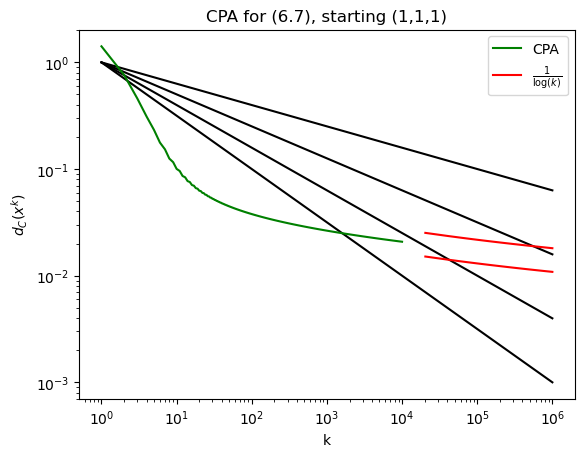

In [25]:
plt.figure()
k =np.linspace(1,10**6,10**6)

plt.loglog(k,k**(-0.2),color='black')
plt.loglog(k,k**(-0.5),color='black')
plt.loglog(k,k**(-0.4),color='black')
plt.loglog(k,k**(-0.3),color='black')
plt.loglog(k[:len(d_c_CPA)-1],d_c_CPA[1:],color='green',label='CPA')

k =np.linspace(1,10**6)
#plt.loglog(k,0.02*np.log(k)**(-0.25),color='blue')
#plt.loglog(k,0.05*np.log(k)**(-0.25),color='blue')
plt.xlabel("k")
plt.ylabel(r'$d_C(x^k)$')
plt.title("CPA for (6.7), starting (1,1,1)")
plt.loglog(k,0.15*np.log(k)**(-1),color='red',label =r'$\frac{1}{\log (k)}$')
plt.loglog(k,0.25*np.log(k)**(-1),color='red')
plt.legend()

#dampDR + tests for (6.7)

Avec $λ =0.5$ on est ramené à DR classique ! (enfin, si le $\eta$ tend vers l'infini...)

On rappelle que si $f(x) = d^2(x,A)$,
$$\text{prox}_{\eta f}(x) = \frac{1}{2\eta +1}x ~+ \frac{2\eta}{2\eta+1}p_A(x)$$
où $p_A$ est le projecteur sur $A$.

In [26]:
def dampDR(x0,eta,lbd,niter):
  k=0
  x=x0
  x_values=[x0]
  dist_c=[np.linalg.norm(proj_C(x0) - x0)]
  while k<niter:
    if isinC(x) : return x_values,dist_c
    y = (1/(2*eta+1))*(x + 2*eta*np.array(proj_v2(x)))
    #print("y=", y)
    z = (1/(2*eta+1))*(2*y-x + 2*eta*np.array(proj_primalexpcone(2*y-x)[0]))
    #print("z=",z)
    x = x + 2*lbd*(z-y)
    #print("x=",x)
    x_values.append(x)
    dist_c.append(np.linalg.norm(proj_C(x) - x))
    k+=1
  return x_values,dist_c

In [27]:
def dampDR_double_eta(x0,eta_prox,eta_v2,lbd,niter):
  k=0
  x=x0
  x_values=[x0]
  dist_c=[np.linalg.norm(proj_C(x0) - x0)]
  while k<niter:
    if isinC(x) : return x_values,dist_c
    y = (1/(2*eta_v2+1))*(x + 2*eta_v2*np.array(proj_v2(x)))
    #print("y=", y)
    z = (1/(2*eta_prox+1))*(2*y-x + 2*eta_prox*np.array(proj_primalexpcone(2*y-x)[0]))
    #print("z=",z)
    x = x + 2*lbd*(z-y)
    #print("x=",x)
    x_values.append(x)
    dist_c.append(np.linalg.norm(proj_C(x) - x))
    k+=1
  return x_values,dist_c

In [28]:
def dampDR_maj(x0,eta0,lbd,niter):
  k=0
  x=x0
  x_values=[x0]
  dist_c=[np.linalg.norm(proj_C(x0) - x0)]
  eta = eta0
  while k<niter:
    if isinC(x) : return x_values,dist_c
    y = (1/(2*eta+1))*(x + 2*eta*np.array(proj_v2(x)))
    #print("y=", y)
    z = (1/(2*eta+1))*(2*y-x + 2*eta*np.array(proj_primalexpcone(2*y-x)[0]))
    #print("z=",z)
    x = x + 2*lbd*(z-y)
    #print("x=",x)
    x_values.append(x)
    dist_c.append(np.linalg.norm(proj_C(x) - x))
    k+=1
    if eta > 0.05:
      eta = eta/k
  return x_values,dist_c

In [29]:
def DR(x0,niter):
  k=0
  x=x0
  x_values=[x0]
  dist_c=[np.linalg.norm(proj_C(x0) - x0)]
  while k<niter:
    if isinC(x) : return x_values,dist_c
    y = 2*np.array(proj_primalexpcone(x)[0]) - np.array(x)
    print("y=", y)
    print("p(y)=",proj_v2(y) )
    z = 2*np.array(proj_v2(y)) - np.array(y)
    print("z=",z)
    x = 0.8*x + 0.2*z
    print("x=",x)
    x_values.append(x)
    dist_c.append(np.linalg.norm(proj_C(x) - x))
    k+=1
  return x_values,dist_c

In [30]:
x_DR,d_DR = DR(np.array([1,1,2]),10**2) #test

y= [ 2.26077802  0.4548299  -0.82584049]
p(y)= [0, 0.4548299042605275, -0.8258404879863894]
z= [-2.26077802  0.4548299  -0.82584049]
x= [0.3478444  0.89096598 1.4348319 ]
y= [ 1.5236545   0.09274035 -0.80214393]
p(y)= [0, 0.0927403537773075, -0.8021439349406303]
z= [-1.5236545   0.09274035 -0.80214393]
x= [-0.02645538  0.73132086  0.98743673]
y= [ 1.00594767 -0.12994045 -0.69407936]
p(y)= [0, -0.1299404546342764, -0.6940793581091358]
z= [-1.00594767 -0.12994045 -0.69407936]
x= [-0.22235384  0.55906859  0.65113352]
y= [ 0.64652117 -0.25262084 -0.55151325]
p(y)= [0, -0.2526208446464297, -0.551513248612957]
z= [-0.64652117 -0.25262084 -0.55151325]
x= [-0.30718731  0.39673071  0.41060416]
y= [ 0.40580964 -0.30993229 -0.39951919]
p(y)= [0, -0.3099322902487315, -0.3995191907753407]
z= [-0.40580964 -0.30993229 -0.39951919]
x= [-0.32691177  0.25539811  0.24857949]
y= [ 0.32691177 -0.25539811 -0.24857949]
p(y)= [0, -0.2553981065974564, -0.24857949251512396]
z= [-0.32691177 -0.25539811 -0.248579

In [31]:
print(x_DR)

[array([1, 1, 2]), array([0.3478444 , 0.89096598, 1.4348319 ]), array([-0.02645538,  0.73132086,  0.98743673]), array([-0.22235384,  0.55906859,  0.65113352]), array([-0.30718731,  0.39673071,  0.41060416]), array([-0.32691177,  0.25539811,  0.24857949]), array([-0.32691177,  0.15323886,  0.1491477 ]), array([-0.32691177,  0.09194332,  0.08948862]), array([-0.32691177,  0.05516599,  0.05369317]), array([-0.32691177,  0.03309959,  0.0322159 ]), array([-0.32691177,  0.01985976,  0.01932954]), array([-0.32691177,  0.01191585,  0.01159772]), array([-0.32691177,  0.00714951,  0.00695863]), array([-0.32691177,  0.00428971,  0.00417518]), array([-0.32691177,  0.00257382,  0.00250511]), array([-0.32691177,  0.00154429,  0.00150307]), array([-0.32691177,  0.00092658,  0.00090184]), array([-0.32691177,  0.00055595,  0.0005411 ]), array([-3.26911772e-01,  3.33567652e-04,  3.24662069e-04]), array([-3.26911772e-01,  2.00140591e-04,  1.94797241e-04]), array([-3.26911772e-01,  1.20084355e-04,  1.1687

In [32]:
print(d_DR)

[2.449489742783178, 1.7244009659292379, 1.229048976381412, 0.8865516217687671, 0.6483479563495088, 0.48362305971968067, 0.3906385688112924, 0.35118811677083556, 0.3358534651474748, 0.3301586807281512, 0.3280843611744465, 0.32733438826160255, 0.32706397702511447, 0.32696657423333647, 0.3269315021243865, 0.3269188752440891, 0.32691432944779153, 0.32691269294565056, 0.32691210380287433, 0.326911891711215, 0.3269118153581839, 0.3269117878710884, 0.3269117779757334, 0.3269117744134056, 0.32691177313096753, 0.32691177266928984, 0.32691177250308584, 0.3269117724432524, 0.3269117724217124, 0.32691177241395797, 0.3269117724111664, 0.32691177241016145, 0.32691177240979963, 0.3269117724096694, 0.3269117724096225, 0.3269117724096056, 0.32691177240959957, 0.32691177240959735, 0.32691177240959657, 0.3269117724095963, 0.3269117724095962, 0.3269117724095961, 0.3269117724095961, 0.3269117724095961, 0.3269117724095961, 0.3269117724095961, 0.3269117724095961, 0.3269117724095961, 0.3269117724095961, 0.326

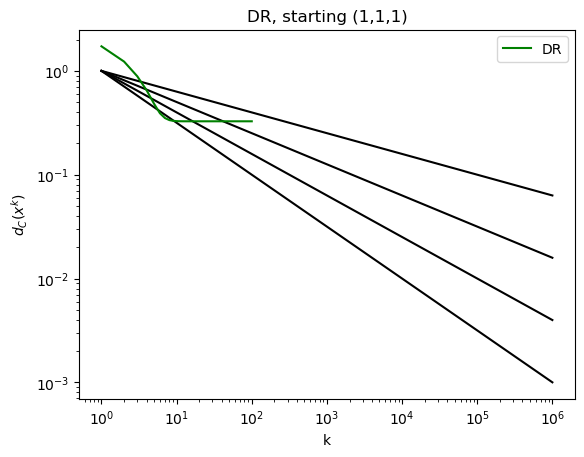

In [33]:
plt.figure()
k =np.linspace(1,10**6,10**6)

plt.loglog(k,k**(-0.2),color='black')
plt.loglog(k,k**(-0.5),color='black')
plt.loglog(k,k**(-0.4),color='black')
plt.loglog(k,k**(-0.3),color='black')
plt.loglog(k[:len(d_DR)-1],d_DR[1:],color='green',label='DR')


plt.xlabel("k")
plt.ylabel(r'$d_C(x^k)$')
plt.title("DR, starting (1,1,1)")
plt.legend()

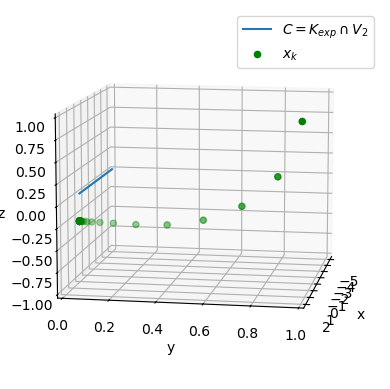

In [34]:
from matplotlib.font_manager import generate_fontconfig_pattern
"""from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

"""

def f(x, y):
    return y*np.exp(x/y)

fig = plt.figure()
ax = plt.axes(projection='3d')
# Can manipulate with 100j and 80j values to make your cone looks different

u, v = np.mgrid[-1:1:100j, 0.2:1:80j]
x = u
y = v
z = f(x, y)

#ax.plot_surface(x, y, z, cmap=cm.coolwarm)
##########
u = np.linspace(-5,0)
x = u
y = [0]*len(u)
z = [0]*len(u)

ax.plot3D(x, y, z,label =r'$C= K_{exp} \cap V_2$')
############
"""u, v = np.mgrid[-1:1:100j, 0:5:80j]
x = u
y = v
z = 0

ax.plot_surface(x, y, z)"""
############
ax.scatter(np.array(x_DR)[:,2],np.array(x_DR)[:,1],np.array(x_DR)[:,0],color='green',label =r'$x_k$')



# Some other effects you may want to try based on your needs:
# ax.plot_surface(x, y, -z, cmap=cm.coolwarm)
# ax.scatter3D(x, y, z, color="b")
# ax.plot_wireframe(x, y, z, color="b")
# ax.plot_wireframe(x, y, -z, color="r")

# Can set your view from different angles.
plt.legend()
ax.view_init(azim=10, elev=10)
ax.set_zlim(-1,1)
ax.set_ylim(0,1)
#ax.set_xlim(-1,1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [314]:
x_v,d_c = dampDR(np.array([1,1,1]),1.1,0.5,10**4) #de base c avec 0.8

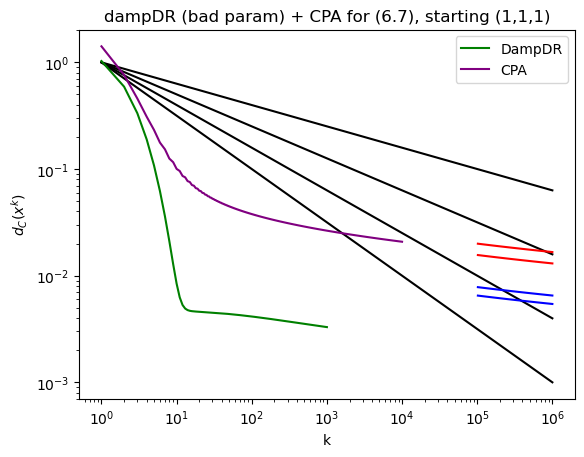

In [36]:
plt.figure()
k =np.linspace(1,10**6,10**6)

plt.loglog(k,k**(-0.2),color='black')
plt.loglog(k,k**(-0.5),color='black')
plt.loglog(k,k**(-0.4),color='black')
plt.loglog(k,k**(-0.3),color='black')
plt.loglog(k[:len(d_c)-1],d_c[1:],color='green',label='DampDR')
plt.loglog(k[:len(d_c_CPA)-1],d_c_CPA[1:],color='purple',label='CPA')


k =np.linspace(1,10**6)
plt.loglog(k[5:],0.09*np.log(k[5:])**(-1),color='blue')
plt.loglog(k[5:],0.075*np.log(k[5:])**(-1),color='blue')

plt.loglog(k[5:],0.18*np.log(k[5:])**(-1),color='red')
plt.loglog(k[5:],0.23*np.log(k[5:])**(-1),color='red')

plt.xlabel("k")
plt.ylabel(r'$d_C(x^k)$')
plt.title("dampDR (bad param) + CPA for (6.7), starting (1,1,1)")
plt.legend()

In [37]:
x_v_2,d_c_2 = dampDR(np.array([1,1,1]),1.3,0.5,10**3)

In [38]:
x_v_3,d_c_3 = dampDR_double_eta(np.array([1,1,1]),0.8,10,0.5,10**3)

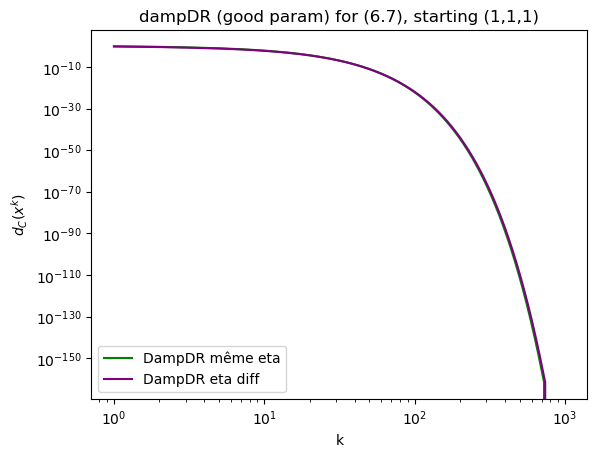

In [39]:
plt.figure()
k =np.linspace(1,10**3,10**3)
plt.loglog(k[:len(d_c_2)-1],d_c_2[1:],color='green',label='DampDR même eta')
plt.loglog(k[:len(d_c_3)-1],d_c_3[1:],color='purple',label='DampDR eta diff')
#plt.loglog(k,np.exp(-0.4*k),color='black')
#plt.loglog(k,np.exp(-0.5*k),color='red',label='exp(-0.5*k)')
#plt.loglog(k[0:10],np.exp(-0.5*k[0:10]),color='red')
plt.xlabel("k")
plt.ylabel(r'$d_C(x^k)$')
plt.title("dampDR (good param) for (6.7), starting (1,1,1)")
plt.legend()

In [40]:
x_v_eta,d_c_eta = dampDR_maj(np.array([1,1,-1]),2,0.5,10**5)

In [41]:
"""

plt.figure()
k =np.linspace(1,10**5,10**5)
plt.loglog(k[:len(d_c_eta)-1],d_c_eta[1:],color='green',label='DampDR')
#plt.loglog(k,np.exp(-0.4*k),color='black')
#plt.loglog(k,np.exp(-0.5*k),color='red',label='exp(-0.5*k)')
plt.loglog(k[0:10],np.exp(-0.5*k[0:10]),color='red')
plt.xlabel("k")
plt.ylabel(r'$d_C(x^k)$')
plt.title("dampDR (good param) for (6.7), starting (1,1,1)")
plt.legend()

"""

'\n\nplt.figure()\nk =np.linspace(1,10**5,10**5)\nplt.loglog(k[:len(d_c_eta)-1],d_c_eta[1:],color=\'green\',label=\'DampDR\')\n#plt.loglog(k,np.exp(-0.4*k),color=\'black\')\n#plt.loglog(k,np.exp(-0.5*k),color=\'red\',label=\'exp(-0.5*k)\')\nplt.loglog(k[0:10],np.exp(-0.5*k[0:10]),color=\'red\')\nplt.xlabel("k")\nplt.ylabel(r\'$d_C(x^k)$\')\nplt.title("dampDR (good param) for (6.7), starting (1,1,1)")\nplt.legend()\n\n'

In [42]:
"""fig = plt.figure()
ax = plt.axes(projection='3d')

x=np.linspace(-0.5,0.5,40)
y=np.linspace(0.15,2,40)
X,Y=np.meshgrid(x,y)
Z=Y*np.exp(X/Y)
ax.plot(x, y, zs=y*np.exp(x/y), zdir='z', label='curve in (x,y)')
ax.plot_surface(X,Y,Z.T,rstride=1,cstride=1,cmap=cm.nipy_spectral_r,linewidth=0,antialiased=False)"""

"fig = plt.figure()\nax = plt.axes(projection='3d')\n\nx=np.linspace(-0.5,0.5,40)\ny=np.linspace(0.15,2,40)\nX,Y=np.meshgrid(x,y)\nZ=Y*np.exp(X/Y)\nax.plot(x, y, zs=y*np.exp(x/y), zdir='z', label='curve in (x,y)')\nax.plot_surface(X,Y,Z.T,rstride=1,cstride=1,cmap=cm.nipy_spectral_r,linewidth=0,antialiased=False)"

In [43]:
def dykstra(x0,niter):
  k=0
  x=x0
  p,q = np.array([0,0,0]), np.array([0,0,0])
  x_values=[x0]
  dist_c=[np.linalg.norm(proj_C(x0) - x0)]
  x1mx=[]
  while k<niter:
    #if isinC(x) : return x_values,dist_c
    y = proj_v2(x+p)
    p = x+p-np.array(y)
    x= np.array(proj_primalexpcone(np.array(y)+q)[0])
    q=np.array(y)+q-x
    x_values.append(x)
    #x_values.append(y)
    dist_c.append(np.linalg.norm(proj_C(x) - x))
    x1mx.append(np.linalg.norm(x_values[-1]-x_values[-2]))
    k+=1
  return x_values,dist_c,x1mx

In [44]:
x_dyk,d_c_dyk,x1mx = dykstra(np.array([1,1,1]),10**3)

C:\Users\o50039002\AppData\Local\Temp\ipykernel_8152\3163685109.py:9: RuntimeWarning: divide by zero encountered in divide
  return y*np.exp(x/y)


-0.018430988522650668


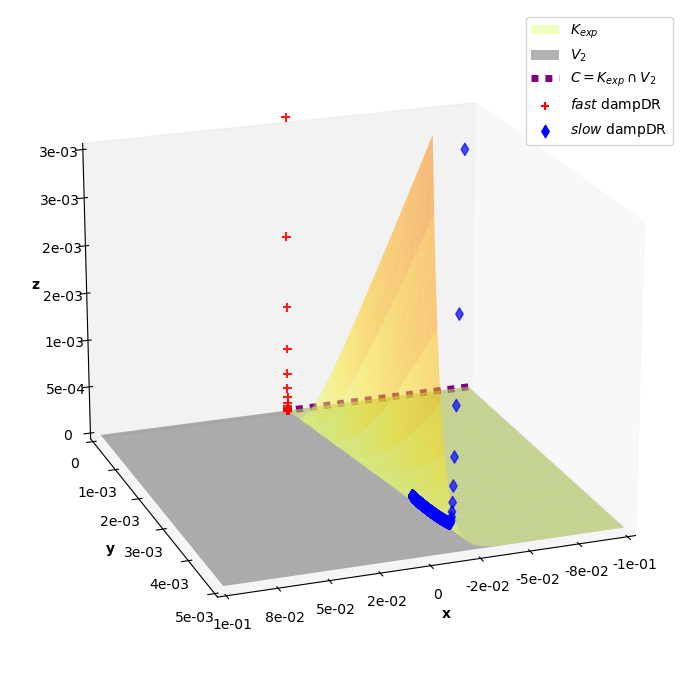

In [293]:
"""from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

"""

def f(x, y):
    return y*np.exp(x/y)

fig = plt.figure(figsize=([11, 7]))
ax = plt.axes(projection='3d')
# Can manipulate with 100j and 80j values to make your cone looks different

u, v = np.mgrid[-1:1:100j, 0.2:1:80j]
x = u
y = v
z = f(x, y)

#ax.plot_surface(x, y, z, cmap=cm.coolwarm)
##########
u, v = np.mgrid[-0.1:-0.001:100j, 0:0.005:200j]
x = u
y = v
z = f(x, y)

ax.plot_surface(x, y, z,cmap = cm.Wistia,alpha=0.5,label=r'$K_{exp}$')

u2, v2 = np.mgrid[-0.1:0.1:9j, 0:0.005:6j]
x2 = u2
y2 = v2
z2 = np.zeros_like(x2)
ax.plot_surface(x2, y2, z2,cmap = cm.gray,alpha=0.3,label=r'$V_2$')

u = np.linspace(-0.1,0)
x = u
y = [0]*len(u)
z = [0]*len(u)
dashes = [1,1]

ax.plot3D(x, y, z,lw=5, linestyle='dashed',dashes=dashes,color="purple",label =r'$C= K_{exp} \cap V_2$')
############
"""u, v = np.mgrid[-1:1:100j, 0:5:80j]
x = u
y = v
z = 0

ax.plot_surface(x, y, z)"""
############
ax.scatter(np.array(x_v_2)[:,2],np.array(x_v_2)[:,1],np.array(x_v_2)[:,0],color='red',label =r'$\mathrm{\mathit{fast~}dampDR}$',marker='+',s=40)
ax.scatter(np.array(x_v)[:10**6,2],np.array(x_v)[:10**6,1],np.array(x_v)[:10**6,0],color='blue',label =r'$\mathrm{\mathit{slow~}dampDR}$',marker='d',s=40)
#ax.scatter(np.array(x_v_CPA)[:10**6,2],np.array(x_v_CPA)[:10**6,1],np.array(x_v_CPA)[:10**6,0],color='green',label ="CPA",s=80)
#ax.scatter(np.array(x_dyk)[:10**4,2],np.array(x_dyk)[:10**4,1],np.array(x_dyk)[:10**4,0],color='orange',label ="Dykstra")

# Définir les coordonnées des deux points
print(np.array(x_v)[-1,2])
del_x = [np.array(x_v)[-1,2], 0]
del_y = [np.array(x_v)[-1,1], 0]
del_z = [np.array(x_v)[-1,0], 0]

num_points = 10000
x_interp = np.linspace(del_x[0], del_x[1], num_points)
y_interp = np.linspace(del_y[0], del_y[1], num_points)
z_interp = np.linspace(del_z[0], del_z[1], num_points)


# Tracer la ligne entre les deux points
#ax.scatter(x_interp, y_interp, z_interp, color='blue',marker='d',s=40)
#ax.plot(del_x, del_y, del_z, color='blue')

"""ax.scatter(np.array(x_v_2)[8,2],np.array(x_v_2)[8,1],np.array(x_v_2)[8,0],color='green') #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y
ax.scatter(np.array(x_v)[8,2],np.array(x_v)[8,1],np.array(x_v)[8,0],color='green') #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y"""


# Some other effects you may want to try based on your needs:
# ax.plot_surface(x, y, -z, cmap=cm.coolwarm)
# ax.scatter3D(x, y, z, color="b")
# ax.plot_wireframe(x, y, z, color="b")
# ax.plot_wireframe(x, y, -z, color="r")

# Can set your view from different angles.
plt.legend()
ax.view_init(azim=70, elev=20)
ax.set_zlim(0,0.003)
ax.set_ylim(0,0.005)
ax.set_xlim(-0.1,0.1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.xaxis.label.set_weight('bold')
ax.yaxis.label.set_weight('bold')
ax.zaxis.label.set_weight('bold')
plt.gca().xaxis.set_major_formatter(FuncFormatter(scientific_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(scientific_formatter))
plt.gca().zaxis.set_major_formatter(FuncFormatter(scientific_formatter))
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
ax.grid(False)
plt.tight_layout()

plt.show()

C:\Users\o50039002\AppData\Local\Temp\ipykernel_8152\3423633092.py:9: RuntimeWarning: divide by zero encountered in divide
  return y*np.exp(x/y)
C:\Users\o50039002\AppData\Local\Temp\ipykernel_8152\3423633092.py:9: RuntimeWarning: invalid value encountered in divide
  return y*np.exp(x/y)


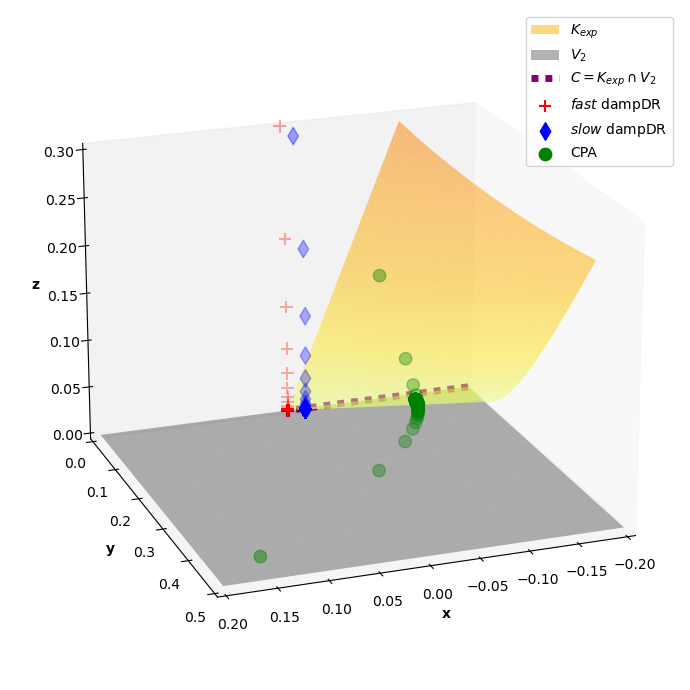

In [448]:
"""from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

"""

def f(x, y):
    return y*np.exp(x/y)

fig = plt.figure(figsize=([11, 7]))
ax = plt.axes(projection='3d')
# Can manipulate with 100j and 80j values to make your cone looks different

u, v = np.mgrid[-0.2:0:100j, 0:0.4:200j]
x = u
y = v
z = f(x, y)

ax.plot_surface(x, y, z,cmap = cm.Wistia,alpha=0.5,label=r'$K_{exp}$')

u2, v2 = np.mgrid[-0.2:0.2:9j, 0:0.5:6j]
x2 = u2
y2 = v2
z2 = np.zeros_like(x2)
ax.plot_surface(x2, y2, z2,cmap = cm.gray,alpha=0.3,label=r'$V_2$')



#ax.plot_surface(x, y, z, cmap=cm.coolwarm)
##########
u = np.linspace(-0.2,0)
x = u
y = [0]*len(u)
z = [0]*len(u)
dashes = [1,1]

ax.plot3D(x, y, z,lw=5, linestyle='dashed',dashes=dashes,color="purple",label =r'$C= K_{exp} \cap V_2$')
############
"""u, v = np.mgrid[-1:1:100j, 0:5:80j]
x = u
y = v
z = 0

ax.plot_surface(x, y, z)"""
############
ax.scatter(np.array(x_v_2)[:,2],np.array(x_v_2)[:,1],np.array(x_v_2)[:,0],color='red',label =r'$\mathrm{\mathit{fast~}dampDR}$',marker='+',s=80)
ax.scatter(np.array(x_v)[:10**4,2],np.array(x_v)[:10**4,1],np.array(x_v)[:10**4,0],color='blue',label =r'$\mathrm{\mathit{slow~}dampDR}$',marker='d',s=80)
ax.scatter(np.array(x_v_CPA)[:10**6,2],np.array(x_v_CPA)[:10**6,1],np.array(x_v_CPA)[:10**6,0],color='green',label ="CPA",s=80)
#ax.scatter(np.array(x_dyk)[:10**4,2],np.array(x_dyk)[:10**4,1],np.array(x_dyk)[:10**4,0],color='orange',label ="Dykstra")

xline, yline = np.linspace(-1,0,200), np.linspace(1e-3,0.2,200)
zline = yline*np.exp(xline/yline)
#ax.plot3D(xline, yline, zline, 'gray')

"""ax.scatter(np.array(x_v_2)[8,2],np.array(x_v_2)[8,1],np.array(x_v_2)[8,0],color='green') #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y
ax.scatter(np.array(x_v)[8,2],np.array(x_v)[8,1],np.array(x_v)[8,0],color='green') #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y"""


# Some other effects you may want to try based on your needs:
# ax.plot_surface(x, y, -z, cmap=cm.coolwarm)
# ax.scatter3D(x, y, z, color="b")
# ax.plot_wireframe(x, y, z, color="b")
# ax.plot_wireframe(x, y, -z, color="r")

# Can set your view from different angles.
plt.legend()
ax.view_init(azim=70, elev=20)
ax.set_zlim(0,0.3)
ax.set_ylim(0,0.5)
ax.set_xlim(-0.2,0.2)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
leg = plt.legend()
ax.xaxis.label.set_weight('bold')
ax.yaxis.label.set_weight('bold')
ax.zaxis.label.set_weight('bold')
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
ax.grid(False)
plt.tight_layout()


plt.show()



C:\Users\o50039002\AppData\Local\Temp\ipykernel_8152\3541187621.py:40: RuntimeWarning: divide by zero encountered in divide
  zline = yline*np.exp(xline/yline)


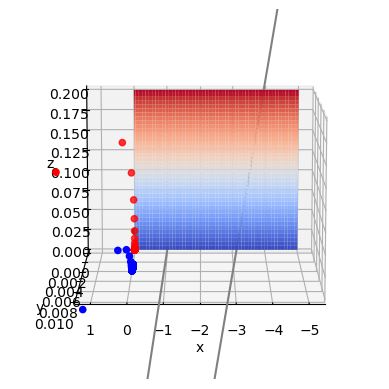

In [163]:
"""from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

"""

def f(x, y):
    return y*np.exp(x/y)

fig = plt.figure()
ax = plt.axes(projection='3d')
# Can manipulate with 100j and 80j values to make your cone looks different

u, v = np.mgrid[-1:1:100j, 0.2:1:80j]
x = u
y = v
z = f(x, y)

#ax.plot_surface(x, y, z, cmap=cm.coolwarm)
##########
u, v = np.mgrid[-5:0:100j, 0:0.2:80j]
x = u
y = 0
z = v

ax.plot_surface(x, y, z, cmap=cm.coolwarm)
############
"""u, v = np.mgrid[-1:1:100j, 0:5:80j]
x = u
y = v
z = 0

ax.plot_surface(x, y, z)"""
############
ax.scatter(np.array(x_v_2)[:,2],np.array(x_v_2)[:,1],np.array(x_v_2)[:,0],color='red')
ax.scatter(np.array(x_v)[:10**4,2],np.array(x_v)[:10**4,1],np.array(x_v)[:10**4,0],color='blue')

xline, yline = np.linspace(-1,1,200), np.linspace(0,0.2,200)
zline = yline*np.exp(xline/yline)
ax.plot3D(xline, yline, zline, 'gray')

ax.scatter(np.array(x_v_2)[8,2],np.array(x_v_2)[8,1],np.array(x_v_2)[8,0],color='green') #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y
ax.scatter(np.array(x_v)[8,2],np.array(x_v)[8,1],np.array(x_v)[8,0],color='green') #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y


# Some other effects you may want to try based on your needs:
# ax.plot_surface(x, y, -z, cmap=cm.coolwarm)
# ax.scatter3D(x, y, z, color="b")
# ax.plot_wireframe(x, y, z, color="b")
# ax.plot_wireframe(x, y, -z, color="r")

# Can set your view from different angles.
ax.view_init(azim=90, elev=10)
ax.set_zlim(0,0.2)
ax.set_ylim(0,0.01)
#ax.set_xlim(-1,1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [48]:
print(np.array(x_v_2)[8])

[2.44578955e-02 8.14153850e-05 3.29499005e-05]


In [49]:
print(np.array(x_v_CPA)[8])

[ 0.0477625   0.11586379 -0.10267552]


In [50]:
print(np.array(x_v)[8])

[ 0.02016252  0.0061696  -0.0178626 ]


In [51]:
fig = plt.figure()

#fig = go.Figure(data=[go.Scatter3d(x = np.array(x_v)[:,0],y = np.array(x_v)[:,1],z = np.array(x_v)[:,2],mode='markers',marker=dict(color='MediumPurple',size=5))])


"""fig = go.Figure(data=[go.Scatter3d(x = np.array(x_v_2)[:,0],y = np.array(x_v_2)[:,1],z = np.array(x_v_2)[:,2],mode='markers',name='dampDR',marker=dict(color='LightSkyBlue',size=5))])"""


#fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,mode='markers')])
fig.show()

C:\Users\o50039002\AppData\Local\Temp\ipykernel_8152\952709281.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 640x480 with 0 Axes>

In [52]:
fig = plt.figure()
#fig = go.Figure(data=[go.Scatter3d(x = np.array(x_v)[:,0],y = np.array(x_v)[:,1],z = np.array(x_v)[:,2],mode='markers',marker=dict(color='MediumPurple',size=5))])

"""
fig = go.Figure(data=[go.Scatter3d(x = np.array(x_v)[:10**3,0],y = np.array(x_v)[:10**3,1],z = np.array(x_v)[:10**3,2],mode='markers',marker=dict(color='LightSkyBlue',size=5))])
"""

#fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,mode='markers')])


fig.show()

C:\Users\o50039002\AppData\Local\Temp\ipykernel_8152\2847400550.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 640x480 with 0 Axes>

In [53]:
print(x_v_2)

[array([1, 1, 1]), array([0.82881722, 0.4635219 , 0.31751484]), array([0.52968837, 0.17066676, 0.07871217]), array([0.31778653, 0.04922877, 0.01992354]), array([0.19027959, 0.01367466, 0.00553432]), array([0.11393284, 0.00379852, 0.00153731]), array([0.06821905, 0.00105514, 0.00042703]), array([0.04084721, 0.0002931 , 0.00011862]), array([2.44578955e-02, 8.14153850e-05, 3.29499005e-05]), array([1.46445424e-02, 2.26153847e-05, 9.15275014e-06]), array([8.76864574e-03, 6.28205131e-06, 2.54243060e-06]), array([5.25036195e-03, 1.74501425e-06, 7.06230721e-07]), array([3.14373524e-03, 4.84726182e-07, 1.96175200e-07]), array([1.88235999e-03, 1.34646162e-07, 5.44931112e-08]), array([1.12709209e-03, 3.74017115e-08, 1.51369753e-08]), array([6.74863785e-04, 1.03893643e-08, 4.20471537e-09]), array([4.04085106e-04, 2.88593453e-09, 1.16797649e-09]), array([2.41952193e-04, 8.01648481e-10, 3.24437914e-10]), array([1.44872609e-04, 2.22680134e-10, 9.01216429e-11]), array([8.67447105e-05, 6.18555927e-11, 

In [54]:
print(np.array(x_v_2)[:,0])

[1.00000000e+000 8.28817215e-001 5.29688372e-001 ... 7.45712824e-223
 4.46507061e-223 2.67352993e-223]


In [55]:
print(d_c_2[-1])

0.0


In [56]:
print(d_c_2[80])

2.2433803174216204e-18


On atteint le **1e-17** en 80 itérations... lunaire !

Convergence en un nombre RIDICULEMENT FAIBLE d'itérations, avec une atteinte de la limite de calcul de python en 700 itérations ! Alors que la projection sur le cone exp est surement pas si optimisée que ça !

L'idée est donc de **BIEN CHOISIR** les paramètres *λ* et *η* (sachant que j'ai pris ces paramètres fixes alors qu'il peuvent etre optimisés à chaque itération !!)

**ATTENTION :** Le dampDR avec 0.8 a un resultat en "log" alors que celui avec 1.5 a un resultat exponentiel décroissante : ma théorie c'est que en fait c'est tj en expo decroissante mais c'est juste que avec 0.8 y'a des erreurs d'arrondis qui font croire que c'est du log

cf ci dessous

"\nk =np.linspace(1,10**6)\nplt.loglog(k[5:],0.09*np.log(k[5:])**(-1),color='blue')\nplt.loglog(k[5:],0.075*np.log(k[5:])**(-1),color='blue')\n\nplt.loglog(k[5:],0.18*np.log(k[5:])**(-1),color='red')\nplt.loglog(k[5:],0.23*np.log(k[5:])**(-1),color='red')"

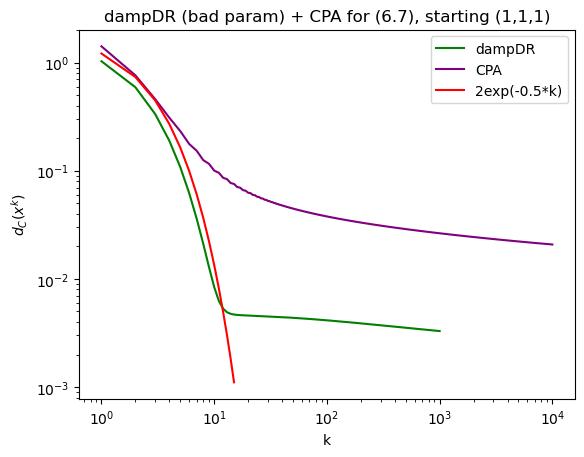

In [57]:
plt.figure()
k =np.linspace(1,10**4,10**4)

"""plt.loglog(k,k**(-0.2),color='black')
plt.loglog(k,k**(-0.5),color='black')
plt.loglog(k,k**(-0.4),color='black')
plt.loglog(k,k**(-0.3),color='black')"""
plt.loglog(k[:len(d_c)-1],d_c[1:len(k)+1],color='green',label='dampDR')
plt.loglog(k[:len(d_c_CPA)-1],d_c_CPA[1:len(k)+1],color='purple',label='CPA')

plt.loglog(k[0:15],2*np.exp(-0.5*k[0:15]),color='red',label='2exp(-0.5*k)')


plt.xlabel("k")
plt.ylabel(r'$d_C(x^k)$')
plt.title("dampDR (bad param) + CPA for (6.7), starting (1,1,1)")
plt.legend()

"""
k =np.linspace(1,10**6)
plt.loglog(k[5:],0.09*np.log(k[5:])**(-1),color='blue')
plt.loglog(k[5:],0.075*np.log(k[5:])**(-1),color='blue')

plt.loglog(k[5:],0.18*np.log(k[5:])**(-1),color='red')
plt.loglog(k[5:],0.23*np.log(k[5:])**(-1),color='red')"""

#Dykstra + tests for (6.7)

In [58]:
def dykstra(x0,niter):
  k=0
  x=x0
  p,q = np.array([0,0,0]), np.array([0,0,0])
  x_values=[x0]
  y_values=[proj_v2(x0)]
  dist_c=[np.linalg.norm(proj_C(x0) - x0)]
  x1mx=[]
  suite = [np.dot(x0 -proj_C(x0),q)]
  suite2 = [0]
  suite3=[]
  suite4=[0]
  suitec=[]
  suiteg=[]
  print(proj_C(x0))
  while k<niter:
    #if isinC(x) : return x_values,dist_c
    y = proj_v2(x+p)
    if k ==1: suite4.pop()
    if k>=1: suite4.append(np.dot(np.array(y_values[-1]) - np.array(y),p))
    y_values.append(y)
    p = x+p-np.array(y)
    #print("y=",y)
    #print(p)
    suite2.append(np.dot(y-proj_C(x0),p))
    x= np.array(proj_primalexpcone(np.array(y)+q)[0])
    #print("x=",x)
    suite3.append(np.dot(x_values[-1] - x,q))
    q=np.array(y)+q-x
    #print("q=",q)
    x_values.append(x)
    suite.append(np.dot(x -proj_C(x0),q))
    #x_values.append(y)
    dist_c.append(np.linalg.norm(proj_C(x) - x))
    x1mx.append(np.linalg.norm(x_values[-1]-x_values[-2]))
    suitec.append(suite[-1] + suite2[-1] - suite[-2] - suite2[-2] + suite3[-1]+suite4[-1] +np.linalg.norm(y - x)**2)
    suiteg.append(suite[-1] + suite2[-1] - suite[-2] - suite2[-2] + suite3[-1]+suite4[-1] +np.linalg.norm(y - x_values[-2])**2+np.linalg.norm(y - x)**2)
    k+=1
  return x_values,dist_c,x1mx,suite,suite2,suite3,suitec,suiteg

In [59]:
x_dyk,d_c_dyk,x1mx,suite,suite2,suite3,suitec,suiteg = dykstra(np.array([1,1,1]),10**3)

[0 0 0]


[1.4187974057061523, 0.12546334942685397, 0.019317574866247775, 0.0037899683851410145, 0.0008394984807591143, 0.000197571040152902, 4.792462900481691e-05, 1.1801858711119072e-05, 2.92831153619941e-06, 7.293248028563202e-07, 1.819880651541667e-07, 4.5454186685517096e-08, 1.1358196863248683e-08, 2.8388807328943184e-09, 7.096366380640417e-10, 1.7739871732255461e-10, 4.434837411261678e-11, 1.1086930381060061e-11, 2.7717122019025564e-12, 6.929255010079771e-13, 1.732310566663923e-13, 4.330772435281544e-14, 2.1653850208777547e-14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

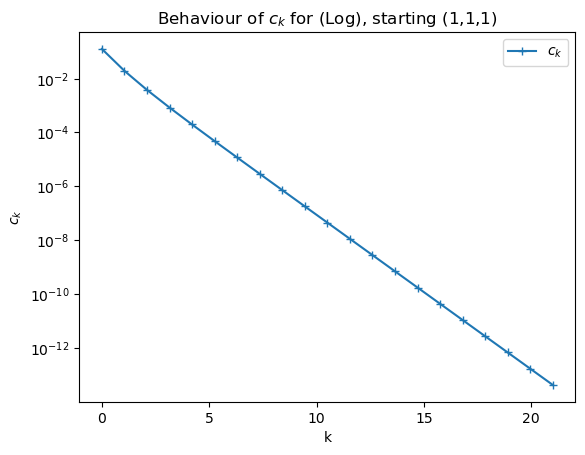

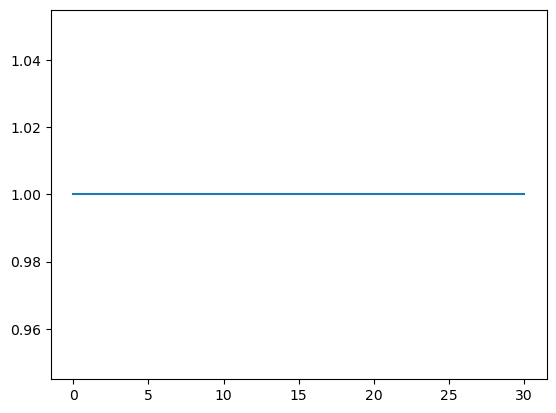

In [60]:
plt.figure()

k = np.linspace(0,len(suitec[1:22]),len(suitec[1:22]))

plt.semilogy(k,suitec[1:22],marker="+",label=r'$c_k$')
#plt.semilogy(k,suiteg[1:30],color='red')
plt.xlabel("k")
plt.ylabel(r'$c_k$')
plt.legend()
plt.title(r"Behaviour of $c_k$ for (Log), starting (1,1,1)")
plt.figure(2)
print(suitec)

verifs = (np.array(suitec)>=0) * 1

k = np.linspace(0,len(verifs[0:30]),len(verifs[0:30]))
plt.plot(k,verifs[0:30])

[1.4187974057061523, 0.12546334942685397, 0.019317574866247775, 0.0037899683851410145, 0.0008394984807591143, 0.000197571040152902, 4.792462900481691e-05, 1.1801858711119072e-05, 2.92831153619941e-06, 7.293248028563202e-07, 1.819880651541667e-07, 4.5454186685517096e-08, 1.1358196863248683e-08, 2.8388807328943184e-09, 7.096366380640417e-10, 1.7739871732255461e-10, 4.434837411261678e-11, 1.1086930381060061e-11, 2.7717122019025564e-12, 6.929255010079771e-13, 1.732310566663923e-13, 4.330772435281544e-14, 2.1653850208777547e-14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

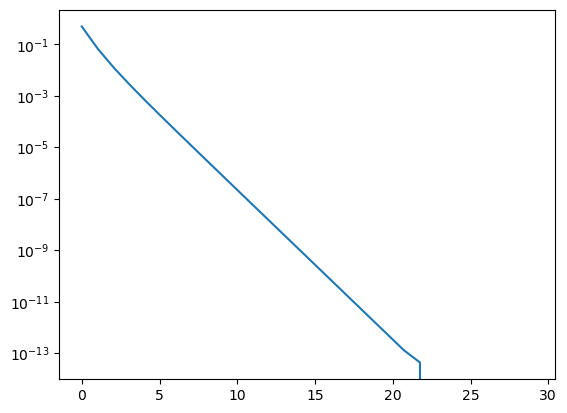

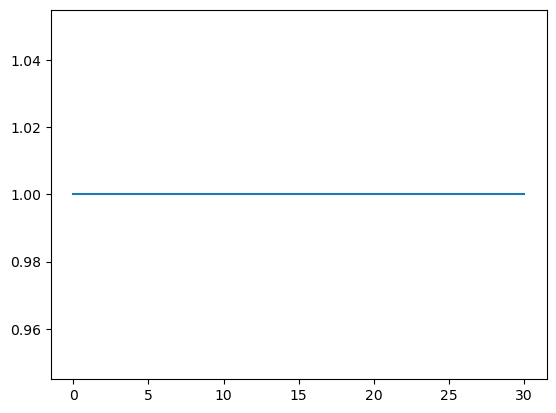

In [61]:
plt.figure()

k = np.linspace(0,len(suiteg[1:30]),len(suiteg[1:30]))
plt.semilogy(k,suiteg[1:30])

plt.figure(2)
print(suitec)

verifs = (np.array(suiteg)>=0) * 1

k = np.linspace(0,len(verifs[0:30]),len(verifs[0:30]))
plt.plot(k,verifs[0:30])

[0, 2.7755575615628914e-17, 6.938893903907228e-17, 0.0, -9.974659986866641e-18, 4.716279450311944e-18, -2.0328790734103208e-19, 1.2095630486791409e-18, -4.667151539371195e-19, -2.8439131204063134e-19, 2.149875499249821e-19, -8.826348008185827e-20, -2.5328270356373707e-20, 1.3495451693802647e-20, -7.298421339708501e-21, -2.1014523461909668e-21, 8.362279005028264e-24, -3.4635603211243806e-22, 6.925295028787462e-23, 3.6352770386179937e-22, 8.00194753836248e-23, 6.288680491741761e-23, 3.2522548399833044e-23, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

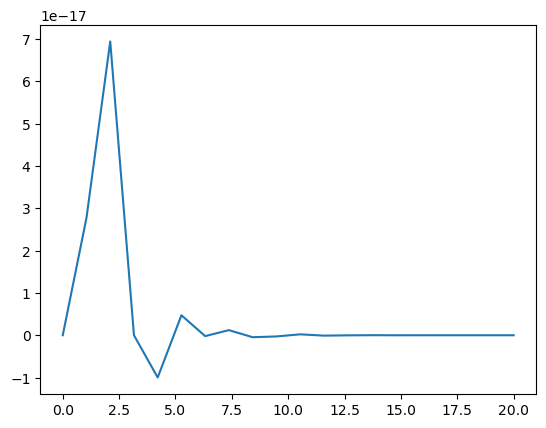

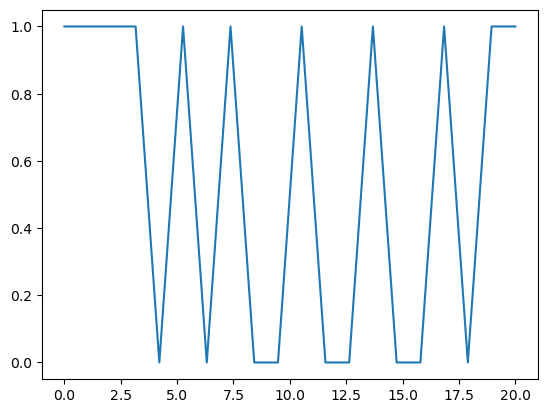

In [62]:
plt.figure()

k = np.linspace(0,len(suite[0:20]),len(suite[0:20]))
plt.plot(k,suite[0:20])

plt.figure(2)
print(suite)

verifs = (np.array(suite)>=0) * 1

k = np.linspace(0,len(verifs[0:20]),len(verifs[0:20]))
plt.plot(k,verifs[0:20])

[0.0, 0.0023386686412635582, 0.00026740214812898816, 3.1228912641686514e-05, 3.750369094031444e-06, 4.5876368814169776e-07, 5.6705034121742426e-08, 7.0476979418301324e-09, 8.78422872372929e-10, 1.0964376399655482e-10, 1.3695515276526935e-11, 1.7113167669886408e-12, 2.1387567647651156e-13, 2.6732033318058957e-14, 3.3413482086416668e-15, 4.176595562628928e-16, 5.22061643674661e-17, 6.525641920963597e-18, 8.154042150399335e-19, 1.0203370114187057e-19, 1.272264942176994e-20, 1.6450222100826186e-21, 3.2522548399833044e-23, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

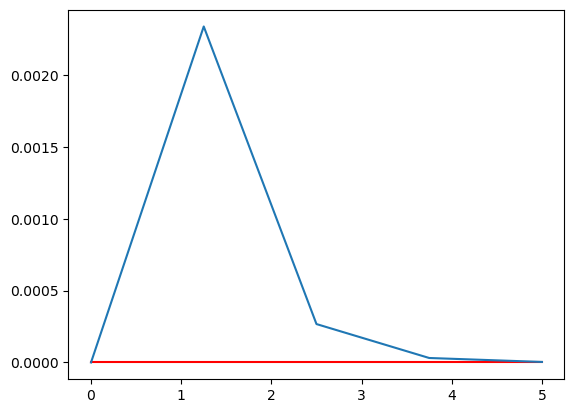

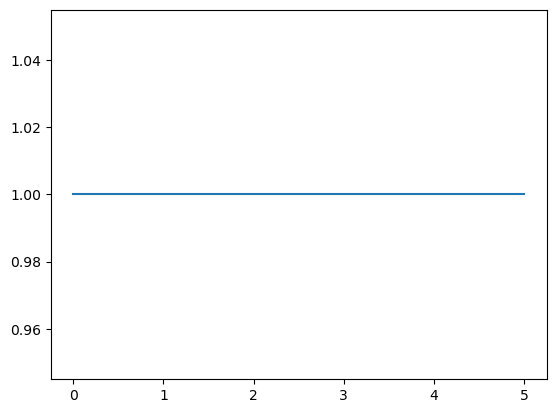

In [63]:
plt.figure()

k = np.linspace(0,len(suite3[0:5]),len(suite3[0:5]))
plt.plot(k,suite[0:5],color='red')
plt.plot(k,suite3[0:5])

plt.figure(2)
print(suite3)

verifs3 = (np.array(suite3)>=0) * 1

k = np.linspace(0,len(verifs3[0:5]),len(verifs3[0:5]))
plt.plot(k,verifs3[0:5])

In [64]:
print(x_dyk)
print(d_c_dyk)

[array([1, 1, 1]), array([0.60897423, 0.43457135, 0.14663124]), array([0.21754672, 0.18531396, 0.02971735]), array([0.09170239, 0.08476826, 0.00666509]), array([0.04206539, 0.04045867, 0.00157564]), array([0.02014219, 0.01975559, 0.00038287]), array([9.85522855e-03, 9.76041730e-03, 9.43537168e-05]), array([4.87447840e-03, 4.85100261e-03, 2.34191683e-05]), array([2.42405825e-03, 2.41821751e-03, 5.83370279e-06]), array([1.20874672e-03, 1.20729004e-03, 1.45579380e-06]), array([6.03554355e-04, 6.03190625e-04, 3.63619731e-07]), array([3.01572626e-04, 3.01481749e-04, 9.08638594e-08]), array([1.50735200e-04, 1.50712488e-04, 2.27108317e-08]), array([7.53548252e-05, 7.53491479e-05, 5.67706636e-09]), array([3.76742192e-05, 3.76728000e-05, 1.41918640e-09]), array([1.88363113e-05, 1.88359565e-05, 3.54786575e-10]), array([9.41795608e-06, 9.41786739e-06, 8.86953908e-11]), array([4.70892815e-06, 4.70890598e-06, 2.21736911e-11]), array([2.35445160e-06, 2.35444606e-06, 5.54340319e-12]), array([1.177222

NameError: name 'sns' is not defined

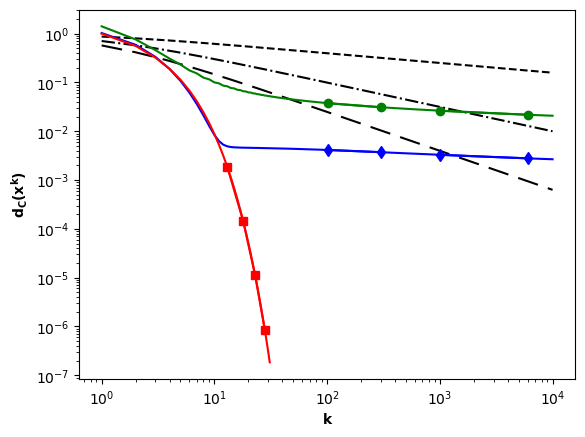

In [473]:
from matplotlib.lines import Line2D
plt.figure()
k =np.linspace(1,10**4,10**4)

plt.loglog(k[:-1],k[1:]**(-0.2),color='black',linestyle='dashed',label=r"$k^{-0.2}$")
plt.loglog(k[:-1],k[1:]**(-0.5),color='black',linestyle='dashdot',label=r"$k^{-0.5}$")
plt.loglog(k[:-1],k[1:]**(-0.8),color='black',dashes=[10, 5, 10, 5],label=r"$k^{-0.8}$")


plt.loglog(k[:len(d_c)-1], d_c[1:len(k)+1], color='blue')
plt.loglog(k[100:500:200], d_c[101:500:200], color='blue', marker='d', label=r'$\mathrm{\mathit{slow~}dampDR}$')
plt.loglog(k[1000:len(d_c)-1:5000], d_c[1001:len(k)+1:5000], color='blue', marker='d')

plt.loglog(k[:31], d_c_2[1:32], color='red')
plt.loglog(k[12:31:5], d_c_2[13:32:5], color='red', marker='s', label=r'$\mathrm{\mathit{fast~}dampDR}$')


plt.loglog(k[:len(d_c_CPA)-1], d_c_CPA[1:len(k)+1], color='green')
plt.loglog(k[100:500:200], d_c_CPA[101:500:200], color='green', marker='o', label='CPA')
plt.loglog(k[1000:len(d_c_CPA)-1:5000], d_c_CPA[1001:len(k)+1:5000], color='green', marker='o')
#plt.loglog(k[:22],d_c_dyk[1:23],color='orange',label='Dykstra')
#plt.loglog(k[:len(x1mx)-1],x1mx[0:len(k[:len(x1mx)-1])],color='cyan',label='Dykstra xk+1-xk')

#plt.loglog(k[0:15],2*np.exp(-0.5*k[0:15]),color='red',label='2exp(-0.5*k)')

plt.xlabel("k",fontweight='bold')
plt.ylabel(r'$\mathbf{d_C(x^k)}$')

custom_legend = [Line2D([0], [0], linestyle='dashed', color='black'),
                 Line2D([0], [0], linestyle='dashdot', color='black'),
                 Line2D([0], [0], dashes=[5, 2.5, 5, 2.5], color='black'),
                 Line2D([0], [0], color='blue', linestyle='-', marker='d', markersize=5),
                 Line2D([0], [0], color='red', linestyle='-', marker='s', markersize=5),
                 Line2D([0], [0], color='green', linestyle='-', marker='o', markersize=5)]

sns.despine(fig, ax, trim=True, right=True, offset=10)

#plt.title("Dykstra, dampDR & CPA for (Log), starting (1,1,1)")
plt.tight_layout()
plt.legend(custom_legend,[r"$k^{-0.2}$", r"$k^{-0.5}$", r"$k^{-0.8}$",r'$\mathrm{\mathit{slow~}dampDR}$',r'$\mathrm{\mathit{fast~}dampDR}$','CPA'])
print(d_c[1])
print(d_c_CPA[1])


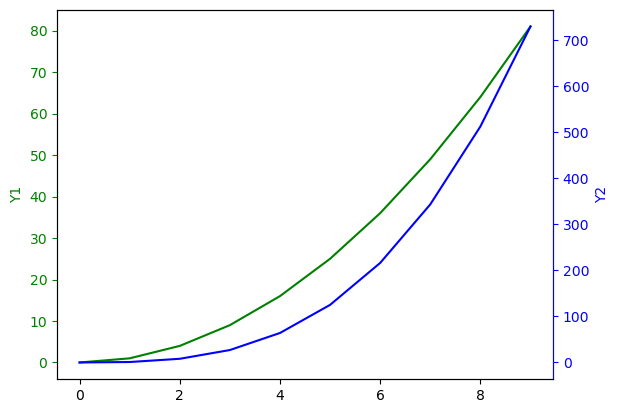

In [469]:
# Données
x = range(10)
y1 = [i**2 for i in x]
y2 = [i**3 for i in x]

# Création du tracé principal
fig, ax1 = plt.subplots()

# Tracer y1 sur l'axe principal
ax1.plot(x, y1, 'g-')
ax1.set_ylabel('Y1', color='g')

# Masquer les lignes et les étiquettes sur l'axe principal
ax1.tick_params(axis='y', colors='g')
ax1.spines['left'].set_color('g')

# Création d'un axe supplémentaire partageant l'axe x
ax2 = ax1.twinx()

# Tracer y2 sur l'axe supplémentaire
ax2.plot(x, y2, 'b-')
ax2.set_ylabel('Y2', color='b')

# Masquer les lignes et les étiquettes sur l'axe supplémentaire
ax2.tick_params(axis='y', colors='b')
ax2.spines['right'].set_color('b')
ax.spines['left'].set_color('red')  # Couleur de la ligne de l'axe des ordonnées à gauche
ax.spines['left'].set_linewidth(2)  # Épaisseur de la ligne de l'axe des ordonnées à gauche


plt.show()


#MPA + test for (6.7)

 Pour confirmer la théorie, on va faire un test avec MPA

In [66]:
def MPA(x0,niter):
  k=0
  x=x0
  x_values=[x0]
  dist_c=[np.linalg.norm(proj_C(x0) - x0)]
  while k<niter:
    x = 0.8*np.array(proj_v2(x)) + 0.2*np.array(proj_primalexpcone(x)[0])
    x_values.append(x)
    dist_c.append(np.linalg.norm(proj_C(x) - x))
    k+=1
  return x_values,dist_c

In [67]:
x_v_MPA,d_c_MPA = MPA(np.array([1,1,1]),10**3)

"\nk =np.linspace(1,10**6)\nplt.loglog(k,0.02*np.log(k)**(-0.25),color='blue')\nplt.loglog(k,0.05*np.log(k)**(-0.25),color='blue')\n\nplt.loglog(k,0.15*np.log(k)**(-1),color='red')\nplt.loglog(k,0.25*np.log(k)**(-1),color='red')"

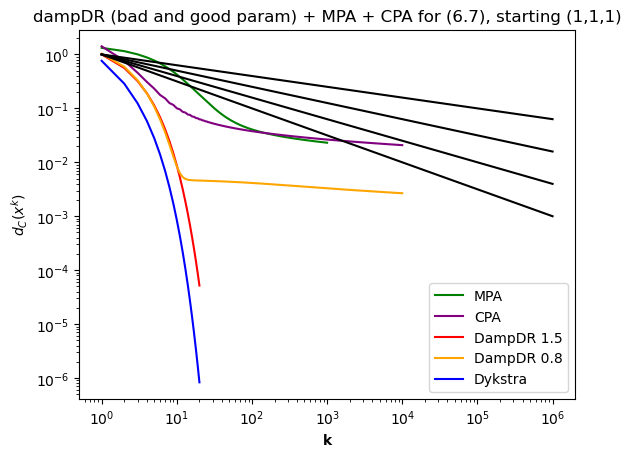

In [348]:
plt.figure()
k =np.linspace(1,10**6,10**6)
"""
plt.loglog(k,k**(-0.2),color='black')
plt.loglog(k,k**(-0.5),color='black')
plt.loglog(k,k**(-0.4),color='black')
plt.loglog(k,k**(-0.3),color='black')"""
plt.loglog(k[:len(d_c_MPA)-1],d_c_MPA[1:],color='green',label='MPA')
plt.loglog(k[:len(d_c_CPA)-1],d_c_CPA[1:],color='purple',label='CPA')
plt.loglog(k[:20],d_c_2[1:21],color='red',label='DampDR 1.5')
plt.loglog(k[:len(d_c)-1],d_c[1:],color='orange',label='DampDR 0.8')
plt.loglog(k[:20],d_c_dyk[1:21],color='blue',label='Dykstra')


plt.loglog(k,k**(-0.2),color='black')
plt.loglog(k,k**(-0.5),color='black')
plt.loglog(k,k**(-0.4),color='black')
plt.loglog(k,k**(-0.3),color='black')

#plt.loglog(k[0:20],np.exp(-0.2*k[0:20]),color='red',label='exp(-0.2*k)')
plt.xlabel("k",fontweight='bold')
plt.ylabel(r'$d_C(x^k)$',fontweight='bold')
plt.title("dampDR (bad and good param) + MPA + CPA for (6.7), starting (1,1,1)")
plt.legend()
"""
k =np.linspace(1,10**6)
plt.loglog(k,0.02*np.log(k)**(-0.25),color='blue')
plt.loglog(k,0.05*np.log(k)**(-0.25),color='blue')

plt.loglog(k,0.15*np.log(k)**(-1),color='red')
plt.loglog(k,0.25*np.log(k)**(-1),color='red')"""



CCL : J'ai l'impression que grâce à dampDR on peut "repousser" la deuxième tendance qui est assez chiante car trop lente...

# Projections for (6.6)

##Projection on $\mathcal{V}_1$ and $C^* = K_{exp}\cap\mathcal{V}_1$

On remarque que $C^* = K_{exp}\cap\mathcal{V}_1 = \{ (x,y,z)\in\mathbb{R},\quad x\leq0, y=0, z\geq0\}$.

Donc, \begin{equation}
\text{proj}_{C}(x) =
\left\{
\begin{array}{ll}
      x- (0,x_2,0), & x_1 \leq 0, x_3\geq0  \\
      x - (0,x_2,x_3), & x_1 \leq 0, x_3<0  \\
      x - (x_1,x_2,0), & x_1 > 0, x_3\geq0  \\
      0, & x_1 > 0, x_3<0  \\
\end{array}
\right.
\end{equation}

In [386]:
def proj_v1(x):
  return [x[0],0,x[2]]

In [387]:
def isinCe(v):
  if v[2] <=0.0 and v[1] ==0.0 and v[0] >=0.0:
    return True
  else : return False

In [388]:
def proj_Ce(x):
  v = np.copy(x)
  if v[2] <=0.0 and v[0]>=0:
    return np.array([v[0],0,v[2]])
  if v[2] <=0.0 and v[0]<0:
    return np.array([0,0,v[2]])
  if v[2] > 0.0 and v[0]>=0:
    return np.array([v[0],0,0])
  else:
    return np.array([0,0,0])

In [389]:
proj_Ce(np.array([1,1,1]))

array([1, 0, 0])

#CPA and DampDR  tests for (6.6)

In [390]:
def CPA_V1(x0,niter):
  k=0
  x=x0
  x_values=[x0]
  dist_c=[np.linalg.norm(proj_Ce(x0) - x0)]
  while k<niter:
    if isinCe(x) : return x_values,dist_c
    if k%2 ==0:
      x = proj_v1(x)
    else :
      x = np.array(proj_primalexpcone(x)[0])
    x_values.append(x)
    dist_c.append(np.linalg.norm(proj_Ce(x) - x))
    k+=1
  return x_values,dist_c

In [391]:
def dampDR_V1(x0,eta,lbd,niter):
  k=0
  x=x0
  x_values=[x0]
  dist_c=[np.linalg.norm(proj_Ce(x0) - x0)]
  while k<niter:
    if isinCe(x) : return x_values,dist_c
    y = (1/(2*eta+1))*(x + 2*eta*np.array(proj_v1(x)))
    z = (1/(2*eta+1))*(2*y-x + 2*eta*np.array(proj_primalexpcone(2*y-x)[0]))
    x = x +2*lbd*(z-y)
    x_values.append(x)
    dist_c.append(np.linalg.norm(proj_Ce(x) - x))
    k+=1
  return x_values,dist_c

In [392]:
def dykstra_V1(x0,niter):
  k=0
  x=x0
  p,q = np.array([0,0,0]), np.array([0,0,0])
  x_values=[x0]
  y_values=[proj_v1(x0)]
  dist_c=[np.linalg.norm(proj_Ce(x0) - x0)]
  x1mx=[]
  suite = [2*np.dot(x0 -proj_C(x0),q)]
  suite2 = [0]
  suite3=[]
  suite4=[0]
  normdiffxy=[]
  suitec=[]
  suiteg=[]
  suited=[]
  suitedelta=[]
  suiterapport=[]
  while k<niter:
    #if isinC(x) : return x_values,dist_c
    y = proj_v1(x+p)
    if k ==1: suite4.pop()
    if k>=1: suite4.append(2*np.dot(np.array(y_values[-1]) - np.array(y),p))
    y_values.append(y)
    suite2.append(2*np.dot(y -proj_Ce(x0),p))
    p = x+p-np.array(y)
    x= np.array(proj_primalexpcone(np.array(y)+q)[0])
    suite3.append(2*np.dot(x_values[-1] - x,q))
    normdiffxy.append(np.linalg.norm(y - x)**2)
    q=np.array(y)+q-x
    #print(q)
    #x_values.append(y)
    x_values.append(x)
    suite.append(2*np.dot(x -proj_Ce(x0),q))
    dist_c.append(np.linalg.norm(proj_Ce(x) - x))
    x1mx.append(np.linalg.norm(x_values[-1]-x_values[-2]))
    suitec.append(suite[-1] + suite2[-1] - suite[-2] - suite2[-2] + suite3[-1]+suite4[-1] +np.linalg.norm(y - x)**2)
    suitedelta.append((suite[-1] + suite2[-1] - suite[-2] - suite2[-2] + suite3[-1]+suite4[-1] +np.linalg.norm(y - x)**2)/(np.linalg.norm(y - x_values[-2])**2))
    suiterapport.append((np.linalg.norm(y - x)**2)/(np.linalg.norm(y - x_values[-2])**2))
    suiteg.append(suite[-1] + suite2[-1] - suite[-2] - suite2[-2] + suite3[-1]+suite4[-1] +np.linalg.norm(y - x_values[-2])**2+np.linalg.norm(y - x)**2)
    suited.append((suiteg[-1])/(np.linalg.norm(y - x_values[-2])**2))
    k+=1
  return x_values,dist_c,x1mx,suite,suite2,suite3,suite4,normdiffxy,suitec,suiteg,suited,suitedelta,suiterapport

In [393]:
x_v_CPA_V1,d_c_CPA_V1 = CPA_V1(np.array([1,1,1]),10**4)

In [394]:
print(x_v_CPA_V1)

[array([1, 1, 1]), [1, 0, 1], array([1.14409574, 0.27025114, 0.38997731]), [1.1440957446279827, 0, 0.38997731068495495], array([1.15606041, 0.12861613, 0.28243344]), [1.156060410143815, 0, 0.28243344231357853], array([1.16027483, 0.08790281, 0.22680511]), [1.1602748314893854, 0, 0.22680510574305096], array([1.162343  , 0.06680361, 0.19082023]), [1.1623429984330287, 0, 0.19082023366316686], array([1.1635326 , 0.05362119, 0.16500696]), [1.1635325984144618, 0, 0.16500695953433187], array([1.16428501, 0.04453106, 0.14533494]), [1.1642850051882543, 0, 0.145334941093383], array([1.16479226, 0.03786265, 0.12973005]), [1.164792256591501, 0, 0.12973005215625935], array([1.16515039, 0.03275708, 0.11699147]), [1.1651503895299395, 0, 0.11699147199011983], array([1.16541228, 0.02872318, 0.10636556]), [1.165412279782057, 0, 0.1063655567139973], array([1.16560918, 0.02545799, 0.09735059]), [1.1656091751185027, 0, 0.09735058836715225], array([1.16576058, 0.02276374, 0.08959717]), [1.1657605757320364, 

In [395]:
print(d_c_CPA_V1)

[1.4142135623730951, 1.0, 0.4744659971347571, 0.38997731068495495, 0.31033974633855266, 0.28243344231357853, 0.2432436221830869, 0.22680510574305096, 0.20217587370246223, 0.19082023366316686, 0.17350080177601188, 0.16500695953433187, 0.15200414737562803, 0.145334941093383, 0.13514239520418567, 0.12973005215625935, 0.1214908680946463, 0.11699147199011983, 0.11017555506211957, 0.1063655567139973, 0.10062428393488412, 0.09735058836715225, 0.09244371260464031, 0.08959716641498958, 0.0853528999025325, 0.08285314326604097, 0.07914491871826554, 0.07693122135570815, 0.07366345020772831, 0.07168890577926167, 0.06878787492794047, 0.06701558045976064, 0.06442342505433028, 0.0628238850823483, 0.06049447690033261, 0.05904379107429084, 0.05693986064912272, 0.05561842827265392, 0.05370950504997955, 0.052501079958649555, 0.05076198875451628, 0.049652977250464095, 0.048062721552467595, 0.047041652485678966, 0.045582572131421105, 0.04463969116465239, 0.0432968180976778, 0.04242377303982942, 0.0411843323

"\nk =np.linspace(1,10**6)\nplt.loglog(k[5:],0.09*np.log(k[5:])**(-1),color='blue')\nplt.loglog(k[5:],0.075*np.log(k[5:])**(-1),color='blue')\n\nplt.loglog(k[5:],0.18*np.log(k[5:])**(-1),color='red')\nplt.loglog(k[5:],0.23*np.log(k[5:])**(-1),color='red')"

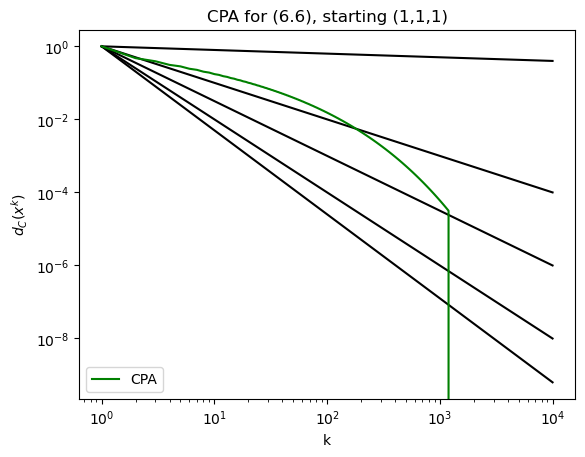

In [396]:
x_v_CPA_V1,d_c_CPA_V1 = CPA_V1(np.array([1,1,1]),10**4)
plt.figure()
k =np.linspace(1,10**4,10**4)

plt.loglog(k,k**(-0.1),color='black')
plt.loglog(k,k**(-1),color='black')
plt.loglog(k,k**(-1.5),color='black')
plt.loglog(k,k**(-2),color='black')
plt.loglog(k,k**(-2.3),color='black')
plt.loglog(k[:len(d_c_CPA_V1)-1],d_c_CPA_V1[1:],color='green',label='CPA')
plt.xlabel("k")
plt.ylabel(r'$d_C(x^k)$')
plt.title("CPA for (6.6), starting (1,1,1)")
plt.legend()
#plt.loglog(k[:len(d_c_CPA)-1],d_c_CPA[1:],color='purple')

"""
k =np.linspace(1,10**6)
plt.loglog(k[5:],0.09*np.log(k[5:])**(-1),color='blue')
plt.loglog(k[5:],0.075*np.log(k[5:])**(-1),color='blue')

plt.loglog(k[5:],0.18*np.log(k[5:])**(-1),color='red')
plt.loglog(k[5:],0.23*np.log(k[5:])**(-1),color='red')"""

"\nk =np.linspace(1,10**6)\nplt.loglog(k[5:],0.09*np.log(k[5:])**(-1),color='blue')\nplt.loglog(k[5:],0.075*np.log(k[5:])**(-1),color='blue')\n\nplt.loglog(k[5:],0.18*np.log(k[5:])**(-1),color='red')\nplt.loglog(k[5:],0.23*np.log(k[5:])**(-1),color='red')"

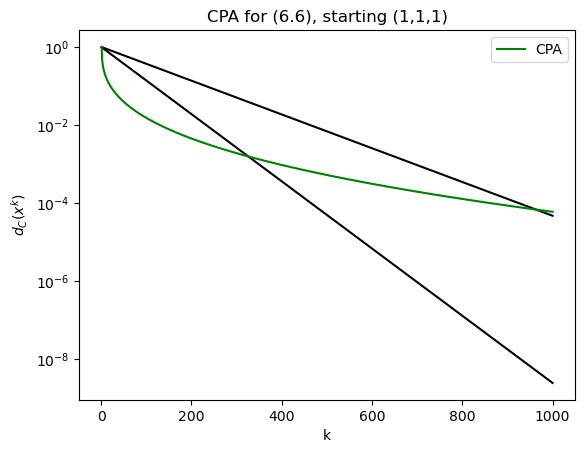

In [397]:
x_v_CPA_V1,d_c_CPA_V1 = CPA_V1(np.array([1,1,1]),10**3)
plt.figure()
k =np.linspace(1,10**3,10**3)

plt.semilogy(k,1.01**(-k),color='black')
plt.semilogy(k,1.02**(-k),color='black')
plt.semilogy(k[:len(d_c_CPA_V1)-1],d_c_CPA_V1[1:],color='green',label='CPA')
#plt.loglog(k[:len(d_c_CPA)-1],d_c_CPA[1:],color='purple')
plt.xlabel("k")
plt.ylabel(r'$d_C(x^k)$')
plt.title("CPA for (6.6), starting (1,1,1)")
plt.legend()

"""
k =np.linspace(1,10**6)
plt.loglog(k[5:],0.09*np.log(k[5:])**(-1),color='blue')
plt.loglog(k[5:],0.075*np.log(k[5:])**(-1),color='blue')

plt.loglog(k[5:],0.18*np.log(k[5:])**(-1),color='red')
plt.loglog(k[5:],0.23*np.log(k[5:])**(-1),color='red')"""

In [398]:
x_v_V1,d_c_V1 = dampDR_V1(np.array([1,1,1]),0.5,0.5,10**4)

C:\Users\o50039002\AppData\Local\Temp\ipykernel_8152\4065441899.py:10: RuntimeWarning: overflow encountered in exp
  tp = max(t0, s0*np.exp(r0/s0))


In [399]:
print(d_c_V1[-20:-1])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [400]:
print(d_c_V1)

[1.4142135623730951, 0.9414848494796737, 0.6783864473818129, 0.522398768310823, 0.4237561073046986, 0.3574497255756597, 0.31029713579233603, 0.275059958482169, 0.2476092924308354, 0.22549310889994842, 0.20719215736691515, 0.1917243761497277, 0.17842882514729536, 0.166843937659127, 0.15663657978762083, 0.1475592782926765, 0.13942355143020155, 0.13208273594038505, 0.1254205884234823, 0.11934350393096387, 0.11377506578159213, 0.10865213863163245, 0.10392200900419597, 0.09954025330395094, 0.09546912179680937, 0.09167629555217761, 0.08813391763667701, 0.08481782910776059, 0.08170696008296109, 0.07878283971548507, 0.07602919838509217, 0.073431642148116, 0.07097738434702541, 0.06865502282943364, 0.06645435385287202, 0.06436621571712227, 0.06238235665215268, 0.06049532262442031, 0.05869836159837332, 0.056985341468875704, 0.055350679411649305, 0.05378928081775222, 0.05229648631062826, 0.050868025609879054, 0.04949997721936706, 0.04818873308977357, 0.04693096754591484, 0.045723609883606145, 0.04

In [401]:
print(x_v_V1)

[array([1, 1, 1]), array([1.07204787, 0.63512557, 0.69498866]), array([1.10419137, 0.42658714, 0.52747662]), array([1.11962522, 0.30065247, 0.42721021]), array([1.1278679 , 0.22139222, 0.36132357]), array([1.13273315, 0.1698321 , 0.31452721]), array([1.13584361, 0.13519469, 0.27929681]), array([1.13795746, 0.11112427, 0.25161355]), array([1.13946293, 0.09380194, 0.229154  ]), array([1.14057508, 0.08090014, 0.21048114]), array([1.14142097, 0.0709776 , 0.19465552]), array([1.14207978, 0.06312464, 0.18103457]), array([1.14260306, 0.05675397, 0.16916215]), array([1.1430256 , 0.0514767 , 0.15870428]), array([1.14337161, 0.04702829, 0.14941003]), array([1.14365843, 0.04322375, 0.14108667]), array([1.1438987 , 0.03993022, 0.13358332]), array([1.14410185, 0.03704986, 0.12677996]), array([1.14427504, 0.03450888, 0.12057969]), array([1.14442378, 0.03225052, 0.11490333]), array([1.14455237, 0.03023029, 0.10968544]), array([1.14466421, 0.02841273, 0.10487137]), array([1.14476201, 0.02676924, 0.100

In [402]:
#print(suitedelta[-1])

In [403]:
x_dyk_V1,d_c_dyk_V1,x1mx_V1,suite,suite2,suite3,suite4,normdiffxy,suitecc,suitegg,suitedd,suitedelta,suiterapport = dykstra_V1(np.array([1,1,1]),10**4)

In [404]:
print(suitecc[-975])

-1.2430554335946678e-08


'plt.figure(2)\nprint(suite)\n\nverifs = (np.array(suite)>=0) * 1\n\nk = np.linspace(0,len(verifs[0:20]),len(verifs[0:20]))\nplt.plot(k,verifs[0:20])'

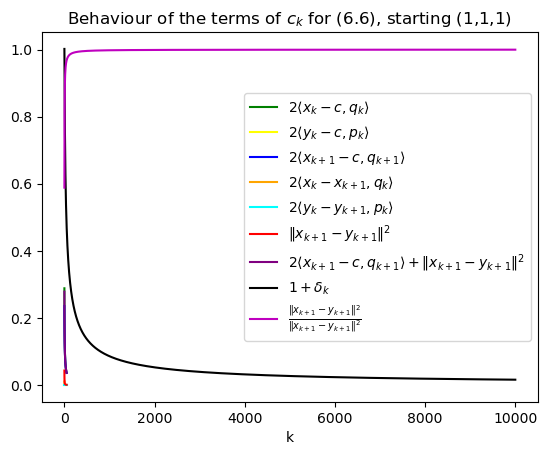

In [405]:
plt.figure()

k = np.linspace(0,len(suite[1:50]),len(suite[1:50]))
k2 = np.linspace(0,len(suite[1:9999]),len(suite[1:9999]))
plt.plot(k,suite[1:50],color='green',label=r"$2\langle x_k- c, q_k\rangle$")
plt.plot(k,suite4[1:50],color='yellow',label=r"$2\langle y_k- c, p_k\rangle$")
plt.plot(k,suite[2:51],color='blue',label=r"$2\langle x_{k+1}- c, q_{k+1}\rangle$")
plt.plot(k,suite3[1:50],color='orange',label=r"$2\langle x_k- x_{k+1}, q_k\rangle$")
plt.plot(k,suite2[1:50],color='cyan',label=r"$2\langle y_k- y_{k+1}, p_k\rangle$")
plt.plot(k,normdiffxy[1:50],color='red',label=r"$\|x_{k+1}-y_{k+1}\|^2$")
plt.plot(k,np.array(suite[2:51])+np.array(normdiffxy[1:50]),color="purple",label=r"$2\langle x_{k+1}- c, q_{k+1}\rangle + \|x_{k+1}-y_{k+1}\|^2$")
plt.plot(k2,np.array([1]*len(suitedelta[1:9999])) + suitedelta[1:9999],color='black',label=r"$1+ \delta_k$")
plt.plot(k2,suiterapport[1:9999],color='m',label=r"$\frac{\|x_{k+1}-y_{k+1}\|^2}{\|x_{k+1}-y_{k+1}\|^2}$")
plt.xlabel("k")
plt.legend()
plt.title(r"Behaviour of the terms of $c_k$ for (6.6), starting (1,1,1)")
"""plt.figure(2)
print(suite)

verifs = (np.array(suite)>=0) * 1

k = np.linspace(0,len(verifs[0:20]),len(verifs[0:20]))
plt.plot(k,verifs[0:20])"""

[0.7541184339430279, 0.00014826117979022113, -0.00033417192560126, -0.0008513789311640069, -0.001115840016496044, -0.0012242308609314457, -0.001248606664318086, -0.001229084042568631, -0.0011873184633764602, -0.0011350845489451209, -0.001078847667419132, -0.0010221630641922847, -0.0009669575943042261, -0.000914231728460879, -0.0008644535321870521, -0.0008177845483185414, -0.0007742115694539713, -0.0007336244962360557, -0.0006958626872446984, -0.0006607425852362121, -0.0006280740682046862, -0.0005976699445718256, -0.0005693512558759164, -0.0005429500131761496, -0.0005183103705086985, -0.0004952888591804919, -0.0004737540724783131, -0.0004535860443228045, -0.00043467547355922486, -0.0004169228874540109, -0.00040023780104545665, -0.00038453790552762, -0.00036974830394583707, -0.0003558008031210909, -0.00034263326487820407, -0.0003301890161314208, -0.00031841631530822134, -0.0003072678714843766, -0.0002967004120772781, -0.0002866742948026109, -0.0002771531596796218, -0.0002681036170827803,

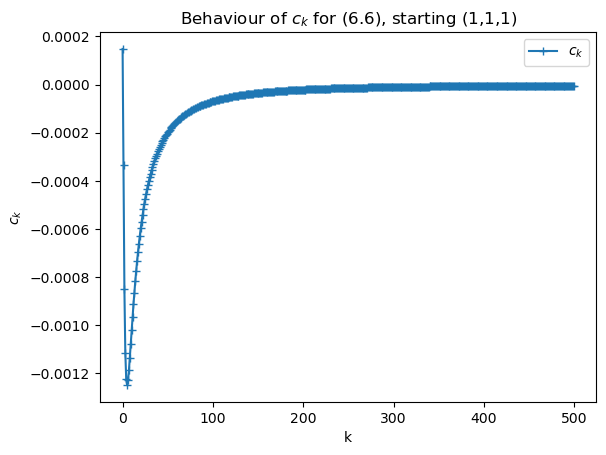

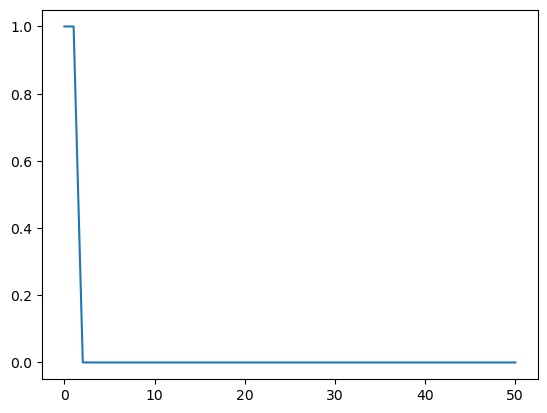

In [406]:
plt.figure()

k = np.linspace(0,len(suitecc[1:500]),len(suitecc[1:500]))
#plt.semilogy(k,suitecc[1:50],label=r"$c_k$",marker='+')
plt.plot(k,suitecc[1:500],label=r"$c_k$",marker='+')

plt.xlabel("k")
plt.ylabel(r'$c_k$')
plt.legend()
plt.title(r"Behaviour of $c_k$ for (6.6), starting (1,1,1)")


plt.figure(2)
print(suitecc)

verifs2 = (np.array(suitecc)>=0) * 1

k = np.linspace(0,len(verifs2[0:50]),len(verifs2[0:50]))
plt.plot(k,verifs2[0:50])

In [407]:
print(suitegg)

[1.7541184339430278, 0.0731839407677997, 0.03986533286483698, 0.02535620660667531, 0.017620925386478862, 0.012973385531880287, 0.009950216977760107, 0.007868613468512572, 0.006372549632095636, 0.005260630043622172, 0.004411579361083228, 0.003748654332549361, 0.003221290279485503, 0.0027950341204496954, 0.00244573556810438, 0.0021560499684134178, 0.0019132553818445685, 0.0017078469021408692, 0.0015326065672509035, 0.0013819730812767196, 0.001251605563182199, 0.0011380758262924183, 0.0010386475976213135, 0.0009511156601519459, 0.0008736870056178477, 0.0008048918993402599, 0.0007435165463510536, 0.0006885515609581176, 0.0006391521371495791, 0.0005946069785488414, 0.0005543138535244958, 0.0005177602090862011, 0.00048450768198937547, 0.00045417963719037845, 0.0004264510763073733, 0.0004010404150486497, 0.0003777027446504597, 0.00035622427929394554, 0.00033641775713240537, 0.00031811861252418984, 0.00030118177537560387, 0.0002854789830713234, 0.00027089651345803267, 0.0002573332653063238, 0.

[1.7541184339430278, 0.0731839407677997, 0.03986533286483698, 0.02535620660667531, 0.017620925386478862, 0.012973385531880287, 0.009950216977760107, 0.007868613468512572, 0.006372549632095636, 0.005260630043622172, 0.004411579361083228, 0.003748654332549361, 0.003221290279485503, 0.0027950341204496954, 0.00244573556810438, 0.0021560499684134178, 0.0019132553818445685, 0.0017078469021408692, 0.0015326065672509035, 0.0013819730812767196, 0.001251605563182199, 0.0011380758262924183, 0.0010386475976213135, 0.0009511156601519459, 0.0008736870056178477, 0.0008048918993402599, 0.0007435165463510536, 0.0006885515609581176, 0.0006391521371495791, 0.0005946069785488414, 0.0005543138535244958, 0.0005177602090862011, 0.00048450768198937547, 0.00045417963719037845, 0.0004264510763073733, 0.0004010404150486497, 0.0003777027446504597, 0.00035622427929394554, 0.00033641775713240537, 0.00031811861252418984, 0.00030118177537560387, 0.0002854789830713234, 0.00027089651345803267, 0.0002573332653063238, 0.

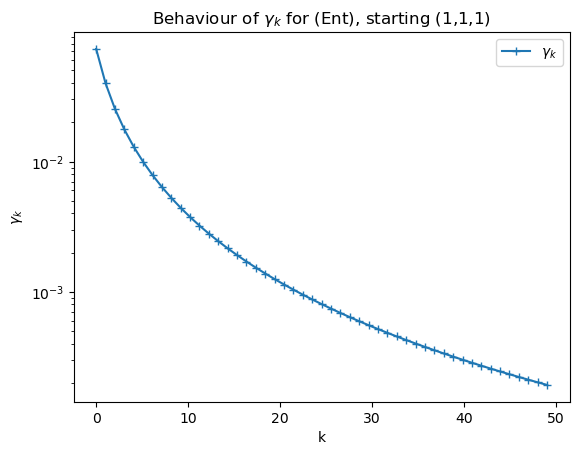

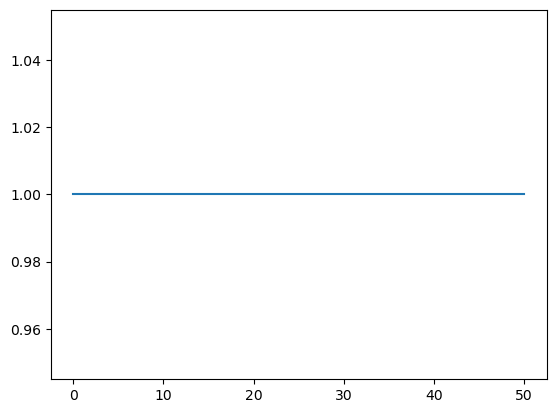

In [408]:
plt.figure()

k = np.linspace(0,len(suitegg[1:50]),len(suitegg[1:50]))
plt.semilogy(k,suitegg[1:50],label=r"$\gamma_k$",marker='+')

plt.xlabel("k")
plt.ylabel(r'$\gamma_k$')
plt.legend()
plt.title(r"Behaviour of $\gamma_k$ for (Ent), starting (1,1,1)")


plt.figure(2)
print(suitegg)

verifs2 = (np.array(suitegg)>=0) * 1

k = np.linspace(0,len(verifs2[0:50]),len(verifs2[0:50]))
plt.plot(k,verifs2[0:50])

'\nplt.figure(2)\nprint(suitedd)\n\nverifs2 = (np.array(suitedd)>=0) * 1\n\nk = np.linspace(0,len(verifs2[0:50]),len(verifs2[0:50]))\nplt.plot(k,verifs2[0:50])'

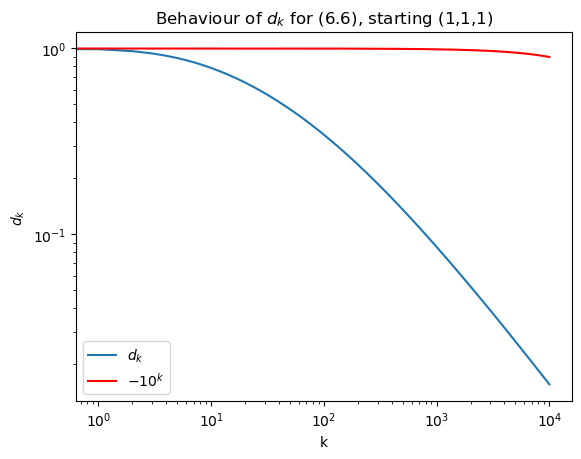

In [409]:
plt.figure()

k = np.linspace(0,len(suitedd[1:10**5]),len(suitedd[1:10**5]))
plt.loglog(k,suitedd[1:10**5],label=r"$d_k$")
plt.semilogy(k,k*(-10**(-5))+1,label=r"$-10^k$",color='red')

plt.xlabel("k")
plt.ylabel(r'$d_k$')
plt.legend()
plt.title(r"Behaviour of $d_k$ for (6.6), starting (1,1,1)")

"""
plt.figure(2)
print(suitedd)

verifs2 = (np.array(suitedd)>=0) * 1

k = np.linspace(0,len(verifs2[0:50]),len(verifs2[0:50]))
plt.plot(k,verifs2[0:50])"""

[0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

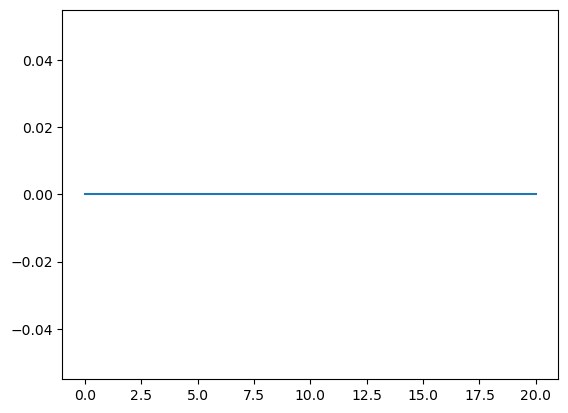

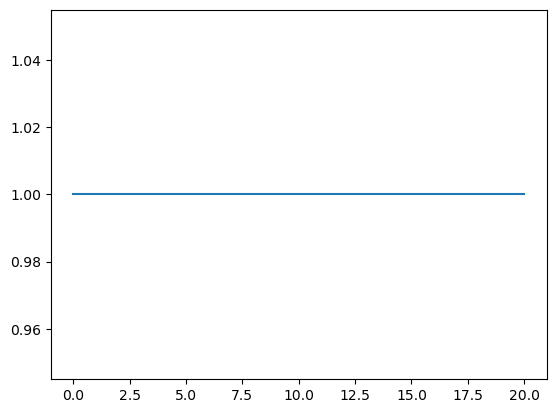

In [410]:
plt.figure()

k = np.linspace(0,len(suite2[0:20]),len(suite2[0:20]))
plt.plot(k,suite2[0:20])

plt.figure(2)
print(suite2)

verifs2 = (np.array(suite2)>=0) * 1

k = np.linspace(0,len(verifs2[0:20]),len(verifs2[0:20]))
plt.plot(k,verifs2[0:20])

In [411]:
x_v_V1_2,d_c_V1_2 = dampDR_V1(np.array([1,1,1]),2,0.5,10**3)

"\nk =np.linspace(1,10**6)\nplt.loglog(k[5:],0.09*np.log(k[5:])**(-1),color='blue')\nplt.loglog(k[5:],0.075*np.log(k[5:])**(-1),color='blue')\n\nplt.loglog(k[5:],0.18*np.log(k[5:])**(-1),color='red')\nplt.loglog(k[5:],0.23*np.log(k[5:])**(-1),color='red')"

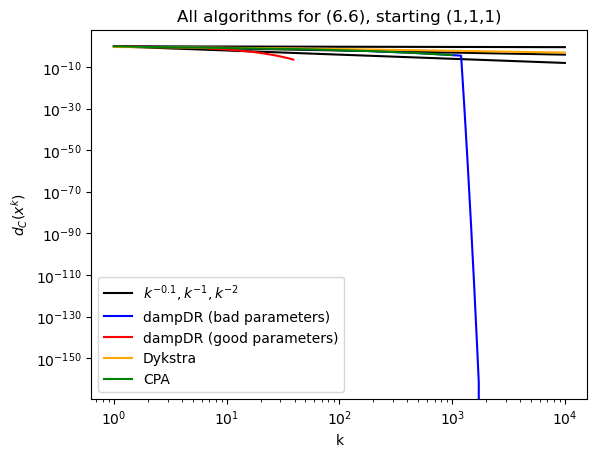

In [413]:
plt.figure()
k =np.linspace(1,10**4,10**4)

plt.loglog(k,k**(-0.1),color='black',label=r"$k^{-0.1}, k^{-1}, k^{-2}$")
plt.loglog(k,k**(-1),color='black')
plt.loglog(k,k**(-2),color='black')
#plt.loglog(k[:len(d_c_V1)-1],d_c_V1[1:],color='green',label='dampDR')
plt.loglog(k[:len(d_c_V1)-1],d_c_V1[1:],color='blue',label='dampDR (bad parameters)')
plt.loglog(k[:39], d_c_V1_2[1:40],color='red',label='dampDR (good parameters)')
plt.loglog(k[:len(d_c_dyk_V1)-1],d_c_dyk_V1[1:],color='orange',label='Dykstra')
plt.loglog(k[:len(d_c_CPA_V1)-1],d_c_CPA_V1[1:],color='green',label="CPA")
#plt.loglog(k[:len(d_c_CPA)-1],d_c_CPA[1:],color='purple')
plt.xlabel("k")
plt.ylabel(r'$d_C(x^k)$')
plt.title("All algorithms for (6.6), starting (1,1,1)")
plt.legend()
"""
k =np.linspace(1,10**6)
plt.loglog(k[5:],0.09*np.log(k[5:])**(-1),color='blue')
plt.loglog(k[5:],0.075*np.log(k[5:])**(-1),color='blue')

plt.loglog(k[5:],0.18*np.log(k[5:])**(-1),color='red')
plt.loglog(k[5:],0.23*np.log(k[5:])**(-1),color='red')"""

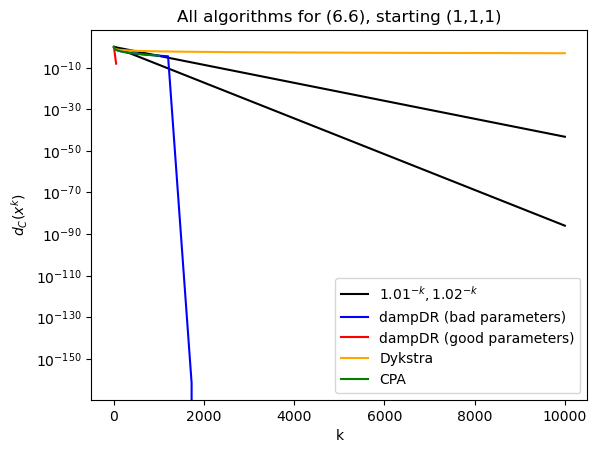

In [415]:
plt.figure()
k =np.linspace(1,10**4,10**4)

"""
plt.loglog(k,k**(-0.2),color='black')
plt.loglog(k,k**(-0.5),color='black')
plt.loglog(k,k**(-0.4),color='black')
plt.loglog(k,k**(-0.3),color='black')"""

plt.semilogy(k,1.01**(-k),color='black',label=r"$1.01^{-k}, 1.02^{-k}$")
plt.semilogy(k,1.02**(-k),color='black')
plt.semilogy(k[:len(d_c_V1)-1],d_c_V1[1:],color='blue',label='dampDR (bad parameters)')
plt.semilogy(k[:49], d_c_V1_2[1:50],color='red',label='dampDR (good parameters)')
plt.semilogy(k[:len(d_c_dyk_V1)-1],d_c_dyk_V1[1:],color='orange',label='Dykstra')
plt.semilogy(k[:len(d_c_CPA_V1)-1],d_c_CPA_V1[1:],color='green',label="CPA")
plt.xlabel("k")
plt.ylabel(r'$d_C(x^k)$')
plt.title("All algorithms for (6.6), starting (1,1,1)")
plt.legend()
#plt.semilogy(k,np.exp(-0.005*k),color='red')

In [416]:
x_v_V1_2,d_c_V1_2 = dampDR_V1(np.array([1,1,1]),2,0.5,10**3)

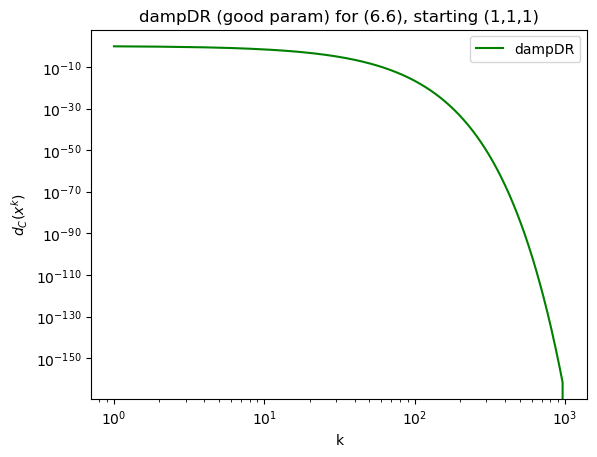

In [417]:
plt.figure()
k =np.linspace(1,10**4,10**4)
"""
plt.loglog(k,k**(-0.1),color='black')
plt.loglog(k,k**(-1),color='black')
plt.loglog(k,k**(-1.5),color='black')
plt.loglog(k,k**(-2),color='black')
plt.loglog(k,k**(-2.3),color='black')"""
plt.loglog(k[:len(d_c_V1_2)-1],d_c_V1_2[1:],color='green',label='dampDR')
#plt.loglog(k[:len(d_c_CPA)-1],d_c_CPA[1:],color='purple')
plt.xlabel("k")
plt.ylabel(r'$d_C(x^k)$')
plt.title("dampDR (good param) for (6.6), starting (1,1,1)")
plt.legend()

In [418]:
print(x_v_V1_2)

[array([1, 1, 1]), array([1.07369698, 0.79323489, 0.43136937]), array([1.08450421, 0.58334154, 0.21745586]), array([1.08666692, 0.41478959, 0.11362984]), array([1.08714443, 0.2895921 , 0.0585082 ]), array([1.0872456 , 0.19983621, 0.02830585]), array([1.0872626 , 0.13678582, 0.01183101]), array([1.08726378, 0.09313794, 0.00346103]), array([1.08726378e+00, 6.33338005e-02, 6.92205422e-04]), array([1.08726378e+00, 4.30669843e-02, 1.38441084e-04]), array([1.08726378e+00, 2.92855493e-02, 2.76882169e-05]), array([1.08726378e+00, 1.99141736e-02, 5.53764338e-06]), array([1.08726378e+00, 1.35416380e-02, 1.10752868e-06]), array([1.08726378e+00, 9.20831385e-03, 2.21505735e-07]), array([1.08726378e+00, 6.26165342e-03, 4.43011470e-08]), array([1.08726378e+00, 4.25792433e-03, 8.86022940e-09]), array([1.08726378e+00, 2.89538854e-03, 1.77204588e-09]), array([1.08726378e+00, 1.96886421e-03, 3.54409176e-10]), array([1.08726378e+00, 1.33882766e-03, 7.08818352e-11]), array([1.08726378e+00, 9.10402810e-04, 

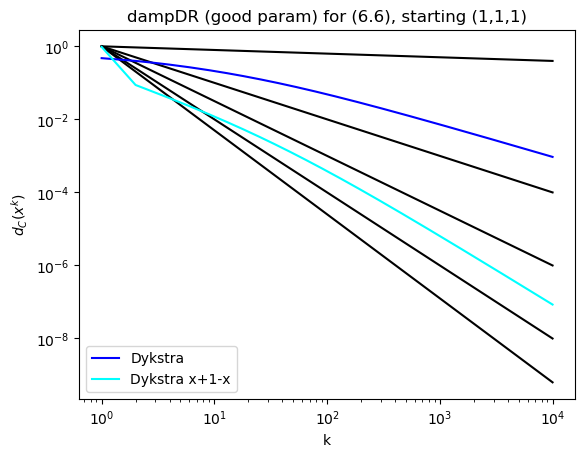

In [419]:
plt.figure()
k =np.linspace(1,10**4,10**4)

plt.loglog(k,k**(-0.1),color='black')
plt.loglog(k,k**(-1),color='black')
plt.loglog(k,k**(-1.5),color='black')
plt.loglog(k,k**(-2),color='black')
plt.loglog(k,k**(-2.3),color='black')
plt.loglog(k[:len(d_c_dyk_V1)-1],d_c_dyk_V1[1:],color='blue',label='Dykstra')
plt.loglog(k[:len(x1mx_V1)-1],x1mx_V1[0:len(k[:len(x1mx_V1)-1])],color='cyan',label='Dykstra x+1-x')
plt.xlabel("k")
plt.ylabel(r'$d_C(x^k)$')
plt.title("dampDR (good param) for (6.6), starting (1,1,1)")
plt.legend()

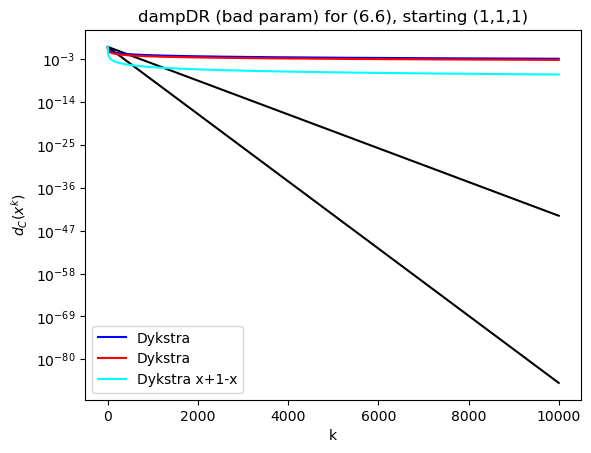

In [421]:
plt.figure()
k =np.linspace(1,10**4,10**4)

"""
plt.loglog(k,k**(-0.2),color='black')
plt.loglog(k,k**(-0.5),color='black')
plt.loglog(k,k**(-0.4),color='black')
plt.loglog(k,k**(-0.3),color='black')"""

plt.semilogy(k,1.01**(-k),color='black')
plt.semilogy(k,1.02**(-k),color='black')
plt.semilogy(k[:len(d_c_dyk_V1)-1],d_c_dyk_V1[1:],color='blue',label='Dykstra')
plt.semilogy(k[:len(d_c_dyk_V1)-1],0.5*np.array(d_c_dyk_V1[1:]),color='red',label='Dykstra')
plt.semilogy(k[:len(x1mx_V1)-1],x1mx_V1[0:len(k[:len(x1mx_V1)-1])],color='cyan',label='Dykstra x+1-x')
plt.xlabel("k")
plt.ylabel(r'$d_C(x^k)$')
plt.title("dampDR (bad param) for (6.6), starting (1,1,1)")
plt.legend()
#plt.semilogy(k,np.exp(-0.005*k),color='red')

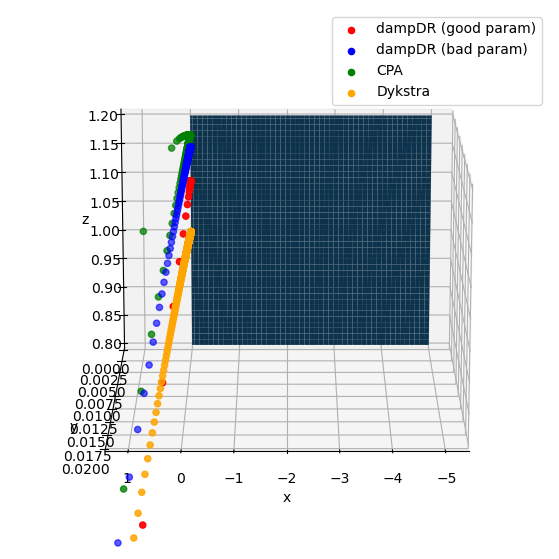

In [422]:
"""from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

"""

def f(x, y):
    return y*np.exp(x/y)

fig = plt.figure(figsize=([11, 7]))
ax = plt.axes(projection='3d')
# Can manipulate with 100j and 80j values to make your cone looks different

u, v = np.mgrid[-1:1:100j, 0.2:1:80j]
x = u
y = v
z = f(x, y)

"""ax.plot_surface(x, y, z, cmap=cm.coolwarm)"""
##########
u, v = np.mgrid[-5:0:100j, 0.8:1.2:80j]
x = u
y = 0
z = v

c1 =ax.plot_surface(x, y, z)

############
"""u, v = np.mgrid[-1:1:100j, 0:5:80j]
x = u
y = v
z = 0

ax.plot_surface(x, y, z)"""
############
ax.scatter(np.array(x_v_V1_2)[:,2],np.array(x_v_V1_2)[:,1],np.array(x_v_V1_2)[:,0],color='red',label="dampDR (good param)")
ax.scatter(np.array(x_v_V1)[:10**4,2],np.array(x_v_V1)[:10**4,1],np.array(x_v_V1)[:10**4,0],color='blue',label="dampDR (bad param)")
ax.scatter(np.array(x_v_CPA_V1)[:10**4,2],np.array(x_v_CPA_V1)[:10**4,1],np.array(x_v_CPA_V1)[:10**4,0],color='green',label="CPA")
ax.scatter(np.array(x_dyk_V1)[:10**4,2],np.array(x_dyk_V1)[:10**4,1],np.array(x_dyk_V1)[:10**4,0],color='orange',label="Dykstra")

"""
ax.scatter(np.array(x_v_V1_2)[8,2],np.array(x_v_V1_2)[8,1],np.array(x_v_V1_2)[8,0],color='green') #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y
ax.scatter(np.array(x_v_V1)[8,2],np.array(x_v_V1)[8,1],np.array(x_v_V1)[8,0],color='green') #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y
"""

# Some other effects you may want to try based on your needs:
# ax.plot_surface(x, y, -z, cmap=cm.coolwarm)
# ax.scatter3D(x, y, z, color="b")
# ax.plot_wireframe(x, y, z, color="b")
# ax.plot_wireframe(x, y, -z, color="r")

plt.legend()
# Can set your view from different angles.
ax.view_init(azim=90, elev=15)
ax.set_zlim(0.8,1.2)
ax.set_ylim(0,0.02)
#ax.set_xlim(-5,5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

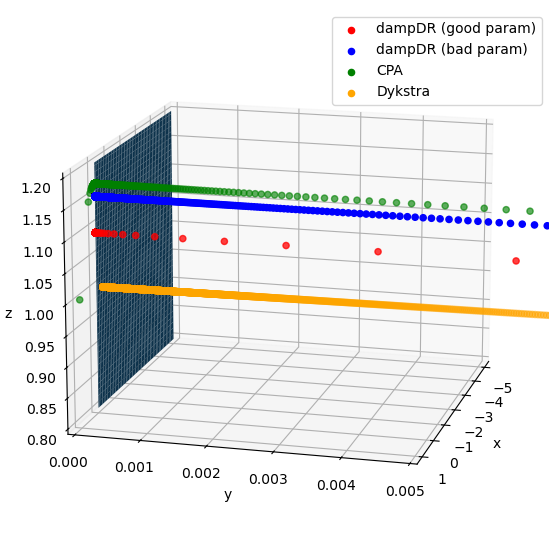

In [423]:
"""from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

"""

def f(x, y):
    return y*np.exp(x/y)

fig = plt.figure(figsize=([11, 7]))
ax = plt.axes(projection='3d')
# Can manipulate with 100j and 80j values to make your cone looks different

u, v = np.mgrid[-1:1:100j, 0.2:1:80j]
x = u
y = v
z = f(x, y)

"""ax.plot_surface(x, y, z, cmap=cm.coolwarm)"""
##########
u, v = np.mgrid[-5:0:100j, 0.8:1.2:80j]
x = u
y = 0
z = v

ax.plot_surface(x, y, z)
############
"""u, v = np.mgrid[-1:1:100j, 0:5:80j]
x = u
y = v
z = 0

ax.plot_surface(x, y, z)"""
############
ax.scatter(np.array(x_v_V1_2)[:,2],np.array(x_v_V1_2)[:,1],np.array(x_v_V1_2)[:,0],color='red',label="dampDR (good param)")
ax.scatter(np.array(x_v_V1)[:10**4,2],np.array(x_v_V1)[:10**4,1],np.array(x_v_V1)[:10**4,0],color='blue',label="dampDR (bad param)")
ax.scatter(np.array(x_v_CPA_V1)[:10**4,2],np.array(x_v_CPA_V1)[:10**4,1],np.array(x_v_CPA_V1)[:10**4,0],color='green',label="CPA")
ax.scatter(np.array(x_dyk_V1)[:10**4,2],np.array(x_dyk_V1)[:10**4,1],np.array(x_dyk_V1)[:10**4,0],color='orange',label="Dykstra")


"""
ax.scatter(np.array(x_v_CPA_V1)[920,2],np.array(x_v_CPA_V1)[920,1],np.array(x_v_CPA_V1)[920,0],color='orange',lw=10) #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y
ax.scatter(np.array(x_v_CPA_V1)[921,2],np.array(x_v_CPA_V1)[921,1],np.array(x_v_CPA_V1)[921,0],color='yellow',lw=20) #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y
ax.scatter(np.array(x_v_V1)[8,2],np.array(x_v_V1)[8,1],np.array(x_v_V1)[8,0],color='green') #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y
"""

# Some other effects you may want to try based on your needs:
# ax.plot_surface(x, y, -z, cmap=cm.coolwarm)
# ax.scatter3D(x, y, z, color="b")
# ax.plot_wireframe(x, y, z, color="b")
# ax.plot_wireframe(x, y, -z, color="r")

plt.legend()
# Can set your view from different angles.
ax.view_init(azim=15, elev=15)
ax.set_zlim(0.8,1.2)
ax.set_ylim(0,5e-3)
#ax.set_xlim(-1,1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [424]:
x_dyk_V1[-1]

array([1.00010129e+00, 1.01396373e-04, 9.32499300e-04])

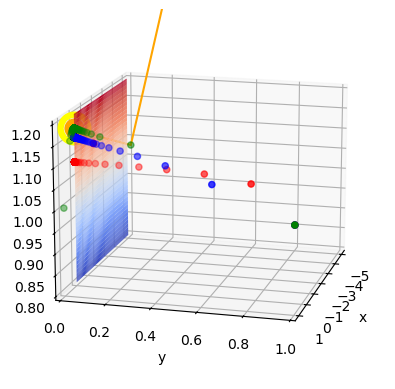

In [425]:
"""from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

"""

def f(x, y):
    return y*np.exp(x/y)

fig = plt.figure()
ax = plt.axes(projection='3d')
# Can manipulate with 100j and 80j values to make your cone looks different

u, v = np.mgrid[-1:1:100j, 0.2:1:80j]
x = u
y = v
z = f(x, y)

"""ax.plot_surface(x, y, z, cmap=cm.coolwarm)"""
##########
u, v = np.mgrid[-5:0:100j, 0.8:1.2:80j]
x = u
y = 0
z = v

ax.plot_surface(x, y, z, cmap=cm.coolwarm)
############
"""u, v = np.mgrid[-1:1:100j, 0:5:80j]
x = u
y = v
z = 0

ax.plot_surface(x, y, z)"""
############
ax.scatter(np.array(x_v_V1_2)[:,2],np.array(x_v_V1_2)[:,1],np.array(x_v_V1_2)[:,0],color='red')
ax.scatter(np.array(x_v_V1)[:10**4,2],np.array(x_v_V1)[:10**4,1],np.array(x_v_V1)[:10**4,0],color='blue')
ax.scatter(np.array(x_v_CPA_V1)[:10**4,2],np.array(x_v_CPA_V1)[:10**4,1],np.array(x_v_CPA_V1)[:10**4,0],color='green')


ax.scatter(np.array(x_v_CPA_V1)[920,2],np.array(x_v_CPA_V1)[920,1],np.array(x_v_CPA_V1)[920,0],color='orange',lw=10) #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y
ax.scatter(np.array(x_v_CPA_V1)[921,2],np.array(x_v_CPA_V1)[921,1],np.array(x_v_CPA_V1)[921,0],color='yellow',lw=20) #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y
ax.scatter(np.array(x_v_V1)[8,2],np.array(x_v_V1)[8,1],np.array(x_v_V1)[8,0],color='purple') #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y

ax.plot3D(np.array(x_v_CPA_V1)[:10**4:2,2],np.array(x_v_CPA_V1)[:10**4:2,1],np.array(x_v_CPA_V1)[:10**4:2,1]*np.exp(np.array(x_v_CPA_V1)[:10**4:2,2]/np.array(x_v_CPA_V1)[:10**4:2,1]),color='orange')


# Some other effects you may want to try based on your needs:
# ax.plot_surface(x, y, -z, cmap=cm.coolwarm)
# ax.scatter3D(x, y, z, color="b")
# ax.plot_wireframe(x, y, z, color="b")
# ax.plot_wireframe(x, y, -z, color="r")

# Can set your view from different angles.
ax.view_init(azim=15, elev=15)
ax.set_zlim(0.8,1.2)
ax.set_ylim(0,1)
#ax.set_xlim(-1,1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

Semi conclusion : j'ai l'imrpession qu'il faut une "disatence de sécurité" avec le cone exponentiel pour que ca converge grave vite, sinon c giga lent wsh

#Comprehension géometrique

$E_1 = \{(x,0,z) \mid x,z \in \mathbb{R}_{-}\times\mathbb{R}\}$ et $E_2 = \{(x,2,z) \mid x,z \in \mathbb{R}_{-}\times\mathbb{R}\}$

In [426]:
def proje1(x):
  if x[2] <=0 : return [x[0],0,x[2]]
  else : return [x[0],0,0]

In [427]:
def proje2(x):
  if x[2] <=0 : return [x[0],2,x[2]]
  else : return [x[0],2,0]

In [428]:
def dampDR_double_eta_e12(x0,e1,e2,lbd,niter):
  k=0
  x=x0
  x_values=[x0]
  dist_c=[np.linalg.norm(proj_C(x0) - x0)]
  while k<niter:
    y = (1/(2*e1+1))*(x + 2*e1*np.array(proje1(x)))
    z = (1/(2*e2+1))*(2*y-x + 2*e2*np.array(proje2(2*y-x)))
    x = x + 2*lbd*(z-y)
    x_values.append(x)
    dist_c.append(np.linalg.norm(proj_C(x) - x))
    k+=1
  return x_values,dist_c

In [429]:
def proxcalc(x0,e1,e2,lbd,niter):
  k=0
  x=x0
  y_values=[]
  z_values=[]
  x_values=[x0]
  while k<niter:
    y = (1/(2*e1+1))*(x + 2*e1*np.array(proje1(x)))
    z = (1/(2*e2+1))*(2*y-x + 2*e2*np.array(proje2(2*y-x)))
    x = x + 2*lbd*(z-y)
    x_values.append(x)
    y_values.append(y)
    z_values.append(z)
    k+=1
  return x_values,y_values,z_values

In [430]:
xv,yv,zv = proxcalc(np.array([1,1,-2]),0.5,5,0.5,10000)

In [431]:
print(zv)

[array([ 1.        ,  1.81818182, -2.        ]), array([ 1.        ,  1.81818182, -2.        ]), array([ 1.        ,  1.81818182, -2.        ]), array([ 1.        ,  1.81818182, -2.        ]), array([ 1.        ,  1.81818182, -2.        ]), array([ 1.        ,  1.81818182, -2.        ]), array([ 1.        ,  1.81818182, -2.        ]), array([ 1.        ,  1.81818182, -2.        ]), array([ 1.        ,  1.81818182, -2.        ]), array([ 1.        ,  1.81818182, -2.        ]), array([ 1.        ,  1.81818182, -2.        ]), array([ 1.        ,  1.81818182, -2.        ]), array([ 1.        ,  1.81818182, -2.        ]), array([ 1.        ,  1.81818182, -2.        ]), array([ 1.        ,  1.81818182, -2.        ]), array([ 1.        ,  1.81818182, -2.        ]), array([ 1.        ,  1.81818182, -2.        ]), array([ 1.        ,  1.81818182, -2.        ]), array([ 1.        ,  1.81818182, -2.        ]), array([ 1.        ,  1.81818182, -2.        ]), array([ 1.        ,  1.81818182, -2.   

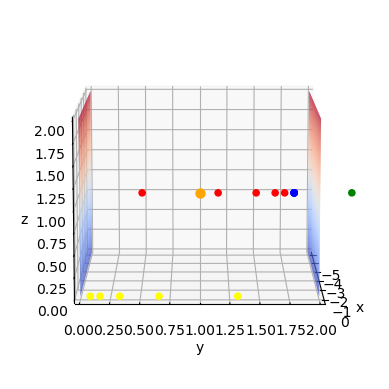

In [432]:
fig = plt.figure()
ax = plt.axes(projection='3d')

##########
u, v = np.mgrid[-5:0:100j, 0:2:80j]
x = u
y = 0
z = v

ax.plot_surface(x, y, z, cmap=cm.coolwarm)
############
u, v = np.mgrid[-5:0:100j, 0:2:80j]
x = u
y = 2
z = v

ax.plot_surface(x, y, z, cmap=cm.coolwarm)
############
ax.scatter(-2,1,1,color='orange', lw=3)

ax.scatter(np.array(yv)[0:5,2],np.array(yv)[0:5,1],np.array(yv)[0:5,0],color='red')
ax.scatter(np.array(zv)[0:5,2],np.array(zv)[0:5,1],np.array(zv)[0:5,0],color='blue')
ax.scatter(np.array(zv)[0:5,2] - np.array(yv)[0:5,2],np.array(zv)[0:5,1]- np.array(yv)[0:5,1],np.array(zv)[0:5,0]- np.array(yv)[0:5,0],color='yellow')
ax.scatter(np.array(xv)[1:6,2],np.array(xv)[1:6,1],np.array(xv)[1:6,0],color='green')

"""
ax.scatter(np.array(x_v_CPA_V1)[920,2],np.array(x_v_CPA_V1)[920,1],np.array(x_v_CPA_V1)[920,0],color='orange',lw=10) #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y
ax.scatter(np.array(x_v_CPA_V1)[921,2],np.array(x_v_CPA_V1)[921,1],np.array(x_v_CPA_V1)[921,0],color='yellow',lw=20) #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y
ax.scatter(np.array(x_v_V1)[8,2],np.array(x_v_V1)[8,1],np.array(x_v_V1)[8,0],color='green') #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y
"""

# Some other effects you may want to try based on your needs:
# ax.plot_surface(x, y, -z, cmap=cm.coolwarm)
# ax.scatter3D(x, y, z, color="b")
# ax.plot_wireframe(x, y, z, color="b")
# ax.plot_wireframe(x, y, -z, color="r")

# Can set your view from different angles.
ax.view_init(azim=0, elev=10)
ax.set_zlim(0,2)
ax.set_ylim(0,2)
#ax.set_xlim(-1,1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

###Mainresult

In [433]:
def proxcalc2(x0,e1,e2,lbd,niter):
  k=0
  x=x0
  y_values=[]
  deuxyx_values=[]
  z_values=[]
  proexp=[]
  dy_x_values=[]
  dx_v2_values=[]
  x_values=[x0]
  dist_c=[np.linalg.norm(proj_C(x0) - x0)]
  while k<niter:
    y = (1/(2*e1+1))*(x + 2*e1*np.array(proj_v2(x)))
    deuxyx_values.append(2*y-x)
    proexp.append(proj_primalexpcone(2*y-x)[0])
    z = (1/(2*e2+1))*(2*y-x + 2*e2*np.array(proj_primalexpcone(2*y-x)[0]))
    x = x + 2*lbd*(z-y)
    x_values.append(x)
    y_values.append(y)
    z_values.append(z)
    dist_c.append(np.linalg.norm(proj_C(x) - x))
    dy_x_values.append(np.linalg.norm(proj_primalexpcone(2*y-x)[0] - (2*y-x)))
    dx_v2_values.append(np.linalg.norm(proj_v2(x) - x))
    k+=1
  return x_values,y_values,z_values,dist_c,dy_x_values,dx_v2_values,deuxyx_values,proexp

In [434]:
xv,yv,zv,dc,dyx,dxv2,deuyx,proexp = proxcalc2(np.array([1,1,1]),2.35,0.6,0.5,10000)

In [435]:
print(zv[-5:-1])

[array([-0.,  0.,  0.]), array([-0.,  0.,  0.]), array([-0.,  0.,  0.]), array([-0.,  0.,  0.])]


In [436]:
print(dyx[0:-1])

[1.9335405512531243, 0.9814949502677536, 0.4841031536176497, 0.23368470476245132, 0.11103812280305524, 0.05220963466317979, 0.024406956934114616, 0.011386865633605006, 0.005316584055983918, 0.00249357349418788, 0.0011748392250808194, 0.0005562066828814804, 0.0002647479750840148, 0.00012677392384766845, 6.111140654967877e-05, 2.9678554821815745e-05, 1.4533099629481963e-05, 7.181698799471602e-06, 3.583446004681163e-06, 1.805604202909201e-06, 9.182249190587277e-07, 4.7088958933492127e-07, 2.431895402131652e-07, 1.2631714770950977e-07, 6.591207378740886e-08, 3.451600332287337e-08, 1.8124799693035724e-08, 9.537589731148021e-09, 5.026827267614806e-09, 2.6525734173795117e-09, 1.4009676043409492e-09, 7.404182632342277e-10, 3.9150768394871564e-10, 2.0709144733292936e-10, 1.0957247800058927e-10, 5.798659688564894e-11, 3.0691483748390124e-11, 1.624633789632441e-11, 8.600585220281898e-12, 4.553300212320229e-12, 2.4107021955930255e-12, 1.2763648821002231e-12, 6.757973025706656e-13, 3.57820873545826

In [437]:
print(dxv2[0:200])

[0.6351023393846351, 0.3723716142901884, 0.20887202469399863, 0.11415946743928368, 0.06146282574885416, 0.03281658873658972, 0.01744381915912068, 0.009250208008933548, 0.004898430943361407, 0.0025937465282232647, 0.0013734032653431004, 0.0007272246955245762, 0.00038506953574826046, 0.000203896468689669, 0.00010796431834923464, 5.716770923755327e-05, 3.027062115927861e-05, 1.6028462878597285e-05, 8.487160567295532e-06, 4.4939988968773795e-06, 2.3795975020148164e-06, 1.2600101605564897e-06, 6.671824135642019e-07, 3.5327681228598884e-07, 1.870620441450531e-07, 9.905039658079368e-08, 5.244773790242982e-08, 2.7771369989803348e-08, 1.4705095433197308e-08, 7.78643011773765e-09, 4.122958212262999e-09, 2.183129388311508e-09, 1.1559791976386294e-09, 6.120974379840909e-10, 3.241090102244309e-10, 1.7161753013478637e-10, 9.087244019896185e-11, 4.811746434777565e-11, 2.547846597043304e-11, 1.3490989955635996e-11, 7.143554490065631e-12, 3.782551978790733e-12, 2.002882387493658e-12, 1.0605374045420964

In [438]:
"""k = np.linspace(0,10**3)
plt.figure()

plt.plot(k,dxv2[0:len(k)],color='r',label="distance de x a V2")
plt.plot(k,dyx[0:len(k)],color='green',label="distance de 2y-x au cone")
plt.ylim(0,1e-3)
plt.legend()"""

'k = np.linspace(0,10**3)\nplt.figure()\n\nplt.plot(k,dxv2[0:len(k)],color=\'r\',label="distance de x a V2")\nplt.plot(k,dyx[0:len(k)],color=\'green\',label="distance de 2y-x au cone")\nplt.ylim(0,1e-3)\nplt.legend()'

In [439]:
print(yv[0:-1])

[array([0.1754386, 1.       , 1.       ]), array([0.11142146, 0.5457662 , 0.46789518]), array([0.06532835, 0.28486465, 0.21196501]), array([0.03664421, 0.14367296, 0.09360995]), array([0.02002798, 0.07050996, 0.04057492]), array([0.01078295, 0.0338635 , 0.01739017]), array([0.0057573 , 0.01599336, 0.00742769]), array([0.00306032, 0.0074551 , 0.00318824]), array([0.00162284, 0.00343556, 0.00139122]), array([0.00085937, 0.00156331, 0.0006299 ]), array([0.00045504, 0.0007106 , 0.00028632]), array([0.00024095, 0.000323  , 0.00013014]), array([1.27583280e-04, 1.46817464e-04, 5.91566783e-05]), array([6.75560589e-05, 6.67352111e-05, 2.68893992e-05]), array([3.57713103e-05, 3.03341869e-05, 1.22224542e-05]), array([1.89411085e-05, 1.37882668e-05, 5.55566100e-06]), array([1.00294227e-05, 6.26739398e-06, 2.52530045e-06]), array([5.31063529e-06, 2.84881545e-06, 1.14786384e-06]), array([2.81201103e-06, 1.29491611e-06, 5.21756292e-07]), array([1.48897554e-06, 5.88598232e-07, 2.37161951e-07]), array(

In [440]:
print(deuyx[0:-1])

[array([-0.64912281,  1.        ,  1.        ]), array([-0.41225941,  0.5457662 ,  0.46789518]), array([-0.24171491,  0.28486465,  0.21196501]), array([-0.13558359,  0.14367296,  0.09360995]), array([-0.07410351,  0.07050996,  0.04057492]), array([-0.03989692,  0.0338635 ,  0.01739017]), array([-0.021302  ,  0.01599336,  0.00742769]), array([-0.01132318,  0.0074551 ,  0.00318824]), array([-0.00600452,  0.00343556,  0.00139122]), array([-0.00317968,  0.00156331,  0.0006299 ]), array([-0.00168366,  0.0007106 ,  0.00028632]), array([-0.00089151,  0.000323  ,  0.00013014]), array([-4.72058136e-04,  1.46817464e-04,  5.91566783e-05]), array([-2.49957418e-04,  6.67352111e-05,  2.68893992e-05]), array([-1.32353848e-04,  3.03341869e-05,  1.22224542e-05]), array([-7.00821014e-05,  1.37882668e-05,  5.55566100e-06]), array([-3.71088639e-05,  6.26739398e-06,  2.52530045e-06]), array([-1.96493506e-05,  2.84881545e-06,  1.14786384e-06]), array([-1.04044408e-05,  1.29491611e-06,  5.21756292e-07]), arr

In [441]:
print(proexp)

[array([0.19359405, 0.16723804, 0.0244745 ]), array([ 0.0661492 ,  0.06744669, -0.00131014]), array([ 0.02144849,  0.02601321, -0.00501926]), array([ 0.0065277 ,  0.0095408 , -0.00362094]), array([ 0.00186038,  0.00332479, -0.00193046]), array([ 0.00049808,  0.00110158, -0.00087438]), array([ 0.0001233 ,  0.00033988, -0.00034464]), array([ 2.49487157e-05,  8.59369232e-05, -1.06286033e-04]), array([ 7.22638952e-07,  3.10914311e-06, -4.53683898e-06]), [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], [0, 0.0, 0], 

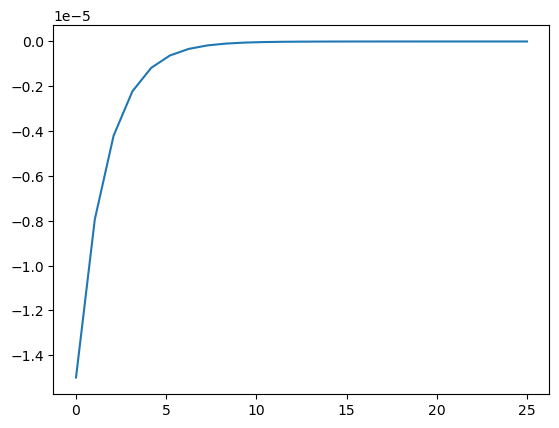

In [442]:
iterés = np.array(zv)[0:-2,0] - np.array(zv)[1:-1,0] #zk - zk+1
#print(iterés[0:50])

plt.figure()
k = np.linspace(0,len(iterés[15:40]),len(iterés[15:40]))
plt.plot(k,iterés[15:40])
#plt.plot(k,k)

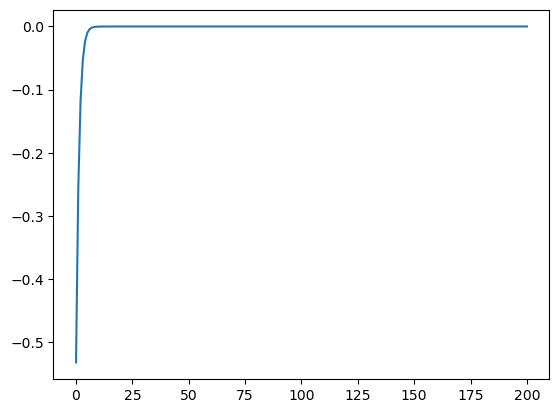

In [443]:
iterésx = np.array(zv)[:,2] - np.array(yv)[:,2]

plt.figure()
k = np.linspace(0,len(iterésx[0:200]),len(iterésx[0:200]))
plt.plot(k,iterésx[0:200])

C:\Users\o50039002\AppData\Local\Temp\ipykernel_8152\3655371143.py:36: RuntimeWarning: invalid value encountered in divide
  ax.plot3D(np.array(yv)[:,2],np.array(yv)[:,1],np.array(yv)[:,1]*np.exp(np.array(yv)[:,2]/np.array(yv)[:,1]),color='orange')
C:\Users\o50039002\AppData\Local\Temp\ipykernel_8152\3655371143.py:37: RuntimeWarning: invalid value encountered in divide
  ax.plot3D(np.array(deuyx)[:,2],np.array(deuyx)[:,1],np.array(deuyx)[:,1]*np.exp(np.array(deuyx)[:,2]/np.array(deuyx)[:,1]),color='purple')
C:\Users\o50039002\AppData\Local\Temp\ipykernel_8152\3655371143.py:38: RuntimeWarning: invalid value encountered in divide
  ax.plot3D(np.array(yv)[:,2],np.array(yv)[:,1],np.array(yv)[:,1]*np.exp(np.array(yv)[:,2]/np.array(yv)[:,1]),color='red')


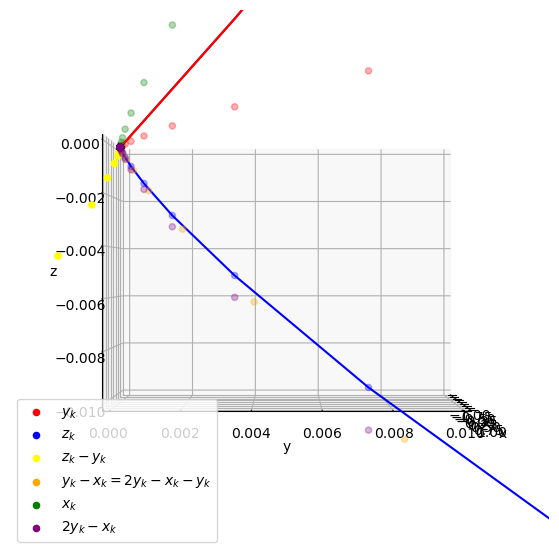

In [444]:
fig = plt.figure(figsize=([11, 7]))
ax = plt.axes(projection='3d')

##########
u, v = np.mgrid[-5:0:100j, 0:2:80j]
x = u
y = 0
z = v

#ax.plot_surface(x, y, z, cmap=cm.coolwarm)
############
u, v = np.mgrid[-5:0:100j, 0:2:80j]
x = u
y = 2
z = v

#ax.plot_surface(x, y, z, cmap=cm.coolwarm)
############
#ax.scatter(-2,1,1,color='orange', lw=3)

"""
ax.scatter(np.array(yv)[0:5,2],np.array(yv)[0:5,1],np.array(yv)[0:5,0],color='red')
ax.scatter(np.array(zv)[0:5,2],np.array(zv)[0:5,1],np.array(zv)[0:5,0],color='blue')
ax.scatter(np.array(zv)[0:5,2] - np.array(yv)[0:5,2],np.array(zv)[0:5,1]- np.array(yv)[0:5,1],np.array(zv)[0:5,0]- np.array(yv)[0:5,0],color='yellow')
ax.scatter(np.array(xv)[1:6,2],np.array(xv)[1:6,1],np.array(xv)[1:6,0],color='green')
"""

ax.scatter(np.array(yv)[:,2],np.array(yv)[:,1],np.array(yv)[:,0],color='red',label =r'$y_k$')
ax.scatter(np.array(zv)[:,2],np.array(zv)[:,1],np.array(zv)[:,0],color='blue',label =r'$z_k$')
#ax.scatter(np.array(proexp)[:,2],np.array(proexp)[:,1],np.array(proexp)[:,0],color='cyan',label =r'$p_C(2y_k-x_k)$')
ax.scatter(np.array(zv)[:,2] - np.array(yv)[:,2],np.array(zv)[:,1]- np.array(yv)[:,1],np.array(zv)[:,0]- np.array(yv)[:,0],color='yellow',label =r'$z_k - y_k$')
ax.scatter(np.array(yv)[:,2] - np.array(xv)[1:,2],np.array(yv)[:,1]- np.array(xv)[1:,1],np.array(yv)[:,0]- np.array(xv)[1:,0],color='orange',label =r'$y_k - x_k = 2y_k - x_k - y_k$')
ax.scatter(np.array(xv)[:,2],np.array(xv)[:,1],np.array(xv)[:,0],color='green',label =r'$x_k$')
#ax.scatter(np.array(xv)[11,2],np.array(xv)[11,1],np.array(xv)[11,0],color='orange',lw=10)
ax.scatter(np.array(deuyx)[:,2],np.array(deuyx)[:,1],np.array(deuyx)[:,0],color='purple',label =r'$2y_k - x_k$')
ax.plot3D(np.array(yv)[:,2],np.array(yv)[:,1],np.array(yv)[:,1]*np.exp(np.array(yv)[:,2]/np.array(yv)[:,1]),color='orange')
ax.plot3D(np.array(deuyx)[:,2],np.array(deuyx)[:,1],np.array(deuyx)[:,1]*np.exp(np.array(deuyx)[:,2]/np.array(deuyx)[:,1]),color='purple')
ax.plot3D(np.array(yv)[:,2],np.array(yv)[:,1],np.array(yv)[:,1]*np.exp(np.array(yv)[:,2]/np.array(yv)[:,1]),color='red')

ax.plot3D(np.array(zv)[:,2],np.array(zv)[:,1],np.array(zv)[:,0],color='blue')

"""
ax.scatter(np.array(x_v_CPA_V1)[920,2],np.array(x_v_CPA_V1)[920,1],np.array(x_v_CPA_V1)[920,0],color='orange',lw=10) #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y
ax.scatter(np.array(x_v_CPA_V1)[921,2],np.array(x_v_CPA_V1)[921,1],np.array(x_v_CPA_V1)[921,0],color='yellow',lw=20) #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y
ax.scatter(np.array(x_v_V1)[8,2],np.array(x_v_V1)[8,1],np.array(x_v_V1)[8,0],color='green') #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y
"""

# Some other effects you may want to try based on your needs:
# ax.plot_surface(x, y, -z, cmap=cm.coolwarm)
# ax.scatter3D(x, y, z, color="b")
# ax.plot_wireframe(x, y, z, color="b")
# ax.plot_wireframe(x, y, -z, color="r")

"""xline, yline =np.mgrid[-1:1e-2:100j, 1e-4:0.01:80j]
zline = yline*np.exp(xline/yline)
ax.plot_surface(xline, yline, zline)"""

# Can set your view from different angles.
plt.legend()
ax.view_init(azim=0, elev=0)
ax.set_zlim(-1e-2,0)
ax.set_xlim(-1,1)
ax.set_ylim(0,1e-2)
#ax.set_xlim(-1,1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [ ]:
"""
dlc = np.array(yv)[:,0] - np.array(yv)[:,1]*np.exp(np.array(yv)[:,2]/np.array(yv)[:,1])
eta1 = 2.35
wk = (1/(2*eta1 + 1))*np.array(xv)[:,0] - np.array(xv)[:,1]*np.exp(np.array(xv)[:,2]/np.array(xv)[:,1])

verif = (dlc>=0) * 1

plt.figure()
k = np.linspace(0,len(verif[0:300]),len(verif[0:300]))
#plt.plot(k,verif[0:300])
plt.plot(k,dlc[0:300])
plt.plot(k,wk[0:300],color='red')"""

"\ndlc = np.array(yv)[:,0] - np.array(yv)[:,1]*np.exp(np.array(yv)[:,2]/np.array(yv)[:,1])\neta1 = 2.35\nwk = (1/(2*eta1 + 1))*np.array(xv)[:,0] - np.array(xv)[:,1]*np.exp(np.array(xv)[:,2]/np.array(xv)[:,1])\n\nverif = (dlc>=0) * 1\n\nplt.figure()\nk = np.linspace(0,len(verif[0:300]),len(verif[0:300]))\n#plt.plot(k,verif[0:300])\nplt.plot(k,dlc[0:300])\nplt.plot(k,wk[0:300],color='red')"

In [ ]:
xv,yv,zv,dc,dyx,dxv2,deuyx,proexp = proxcalc2(np.array([1,1,1]),2.34,0.6,0.5,10000)

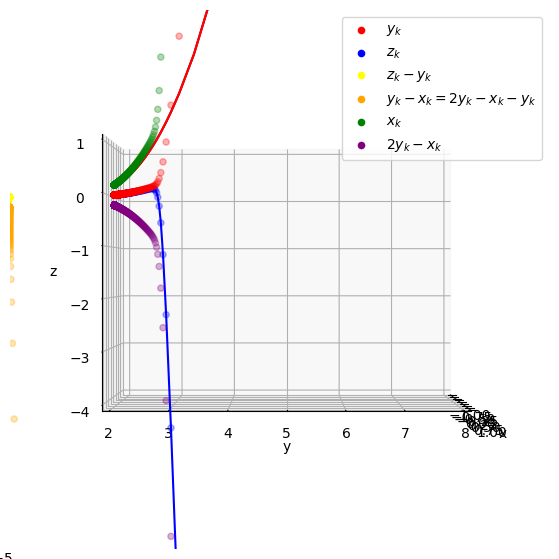

In [ ]:
fig = plt.figure(figsize=([11, 7]))
ax = plt.axes(projection='3d')


ax.scatter(np.array(yv)[:,2],np.array(yv)[:,1],np.array(yv)[:,0],color='red',label =r'$y_k$')
ax.scatter(np.array(zv)[:,2],np.array(zv)[:,1],np.array(zv)[:,0],color='blue',label =r'$z_k$')
#ax.scatter(np.array(proexp)[:,2],np.array(proexp)[:,1],np.array(proexp)[:,0],color='cyan',label =r'$p_C(2y_k-x_k)$')
ax.scatter(np.array(zv)[:,2] - np.array(yv)[:,2],np.array(zv)[:,1]- np.array(yv)[:,1],np.array(zv)[:,0]- np.array(yv)[:,0],color='yellow',label =r'$z_k - y_k$')
ax.scatter(np.array(yv)[:,2] - np.array(xv)[1:,2],np.array(yv)[:,1]- np.array(xv)[1:,1],np.array(yv)[:,0]- np.array(xv)[1:,0],color='orange',label =r'$y_k - x_k = 2y_k - x_k - y_k$')
ax.scatter(np.array(xv)[:,2],np.array(xv)[:,1],np.array(xv)[:,0],color='green',label =r'$x_k$')
#ax.scatter(np.array(yv)[21,2],np.array(yv)[21,1],np.array(yv)[21,0],color='orange',lw=10)
ax.scatter(np.array(deuyx)[:,2],np.array(deuyx)[:,1],np.array(deuyx)[:,0],color='purple',label =r'$2y_k - x_k$')
ax.plot3D(np.array(yv)[:,2],np.array(yv)[:,1],np.array(yv)[:,1]*np.exp(np.array(yv)[:,2]/np.array(yv)[:,1]),color='orange')
ax.plot3D(np.array(deuyx)[:,2],np.array(deuyx)[:,1],np.array(deuyx)[:,1]*np.exp(np.array(deuyx)[:,2]/np.array(deuyx)[:,1]),color='purple')
ax.plot3D(np.array(yv)[:,2],np.array(yv)[:,1],np.array(yv)[:,1]*np.exp(np.array(yv)[:,2]/np.array(yv)[:,1]),color='red')

ax.plot3D(np.array(zv)[:,2],np.array(zv)[:,1],np.array(zv)[:,0],color='blue')

# Can set your view from different angles.
plt.legend()
ax.view_init(azim=0, elev=0)
ax.set_zlim(-4e-6,1e-6)
ax.set_xlim(-1,1)
ax.set_ylim(2e-5,8e-5)
#ax.set_xlim(-1,1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

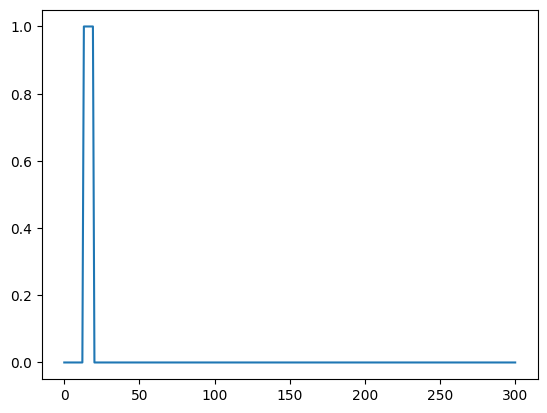

In [ ]:
dlc = np.array(yv)[:,0] - np.array(yv)[:,1]*np.exp(np.array(yv)[:,2]/np.array(yv)[:,1])
verif = (dlc>=0) * 1

plt.figure()
k = np.linspace(0,len(verif[0:300]),len(verif[0:300]))
plt.plot(k,verif[0:300])

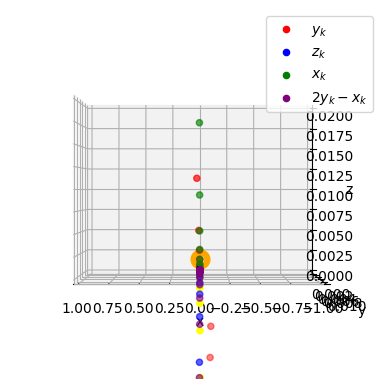

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(np.array(yv)[:,2],np.array(yv)[:,1],np.array(yv)[:,0],color='red',label =r'$y_k$')
ax.scatter(np.array(zv)[:,2],np.array(zv)[:,1],np.array(zv)[:,0],color='blue',label =r'$z_k$')
ax.scatter(np.array(zv)[:,2] - np.array(yv)[:,2],np.array(zv)[:,1]- np.array(yv)[:,1],np.array(zv)[:,0]- np.array(yv)[:,0],color='yellow')
ax.scatter(np.array(xv)[:,2],np.array(xv)[:,1],np.array(xv)[:,0],color='green',label =r'$x_k$')
ax.scatter(np.array(xv)[11,2],np.array(xv)[11,1],np.array(xv)[11,0],color='orange',lw=10)
ax.scatter(np.array(deuyx)[:,2],np.array(deuyx)[:,1],np.array(deuyx)[:,0],color='purple',label =r'$2y_k - x_k$')
#ax.plot3D(np.array(yv)[:,2],np.array(yv)[:,1],np.array(yv)[:,1]*np.exp(np.array(yv)[:,2]/np.array(yv)[:,1]),color='orange')
#ax.plot3D(np.array(deuyx)[:,2],np.array(deuyx)[:,1],np.array(deuyx)[:,1]*np.exp(np.array(deuyx)[:,2]/np.array(deuyx)[:,1]),color='purple')
#ax.plot3D(np.array(yv)[:,2],np.array(yv)[:,1],np.array(yv)[:,1]*np.exp(np.array(yv)[:,2]/np.array(yv)[:,1]),color='red')

plt.legend()
ax.view_init(azim=90, elev=0)
ax.set_zlim(0,2e-2)
ax.set_xlim(-1,1)
ax.set_ylim(0,1e-2)
#ax.set_xlim(-1,1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [ ]:
# Setting du screen coole (1.3 et 0.8 pour e1 et e2)
"""ax.view_init(azim=15, elev=0)
ax.set_zlim(0,3e-3)
ax.set_xlim(-1,1)
ax.set_ylim(4e-3,5e-3)
#ax.set_xlim(-1,1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()"""

'ax.view_init(azim=15, elev=0)\nax.set_zlim(0,3e-3)\nax.set_xlim(-1,1)\nax.set_ylim(4e-3,5e-3)\n#ax.set_xlim(-1,1)\nax.set_xlabel("x")\nax.set_ylabel("y")\nax.set_zlabel("z")\nplt.show()\nax.set_ylabel("y")\nax.set_zlabel("z")\nplt.show()'

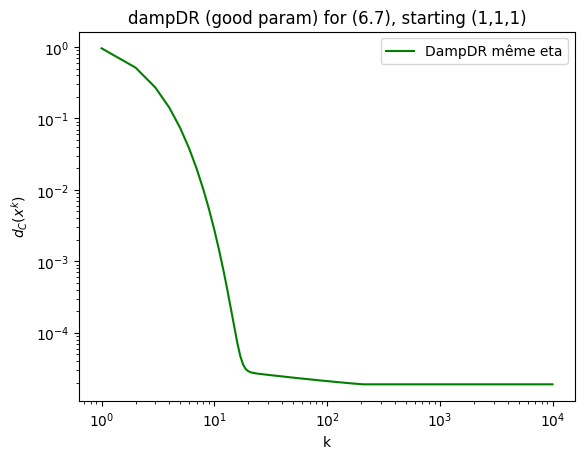

In [ ]:
diff =np.array(xv)[:,1]*np.exp(np.array(xv)[:,0]/np.array(xv)[:,1]) -np.array(xv)[:,2]

plt.figure()
k =np.linspace(1,10**4,10**4)

plt.loglog(k[:len(dc)-1],dc[1:],color='green',label='DampDR même eta')
#plt.loglog(k[:len(diff)],diff[0:-1])
#plt.loglog(k,np.exp(-0.4*k),color='black')
#plt.loglog(k,np.exp(-0.5*k),color='red',label='exp(-0.5*k)')
#plt.loglog(k[0:10],np.exp(-0.5*k[0:10]),color='red')
plt.xlabel("k")
plt.ylabel(r'$d_C(x^k)$')
plt.title("dampDR (good param) for (6.7), starting (1,1,1)")
plt.legend()

In [ ]:
x

array([[-5.        , -5.        , -5.        , ..., -5.        ,
        -5.        , -5.        ],
       [-4.94949495, -4.94949495, -4.94949495, ..., -4.94949495,
        -4.94949495, -4.94949495],
       [-4.8989899 , -4.8989899 , -4.8989899 , ..., -4.8989899 ,
        -4.8989899 , -4.8989899 ],
       ...,
       [-0.1010101 , -0.1010101 , -0.1010101 , ..., -0.1010101 ,
        -0.1010101 , -0.1010101 ],
       [-0.05050505, -0.05050505, -0.05050505, ..., -0.05050505,
        -0.05050505, -0.05050505],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

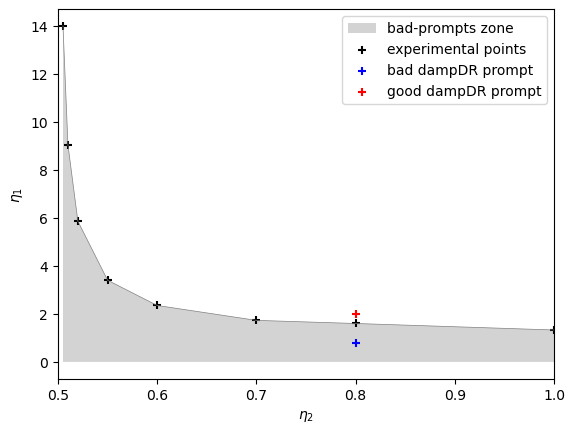

In [447]:
le1 = [0.5,0.505,0.51,0.52,0.55,0.6,0.7,0.8,1] #TA MERE G INVERSER
le2=[51.2,13.99,9.04,5.86,3.4,2.35,1.73,1.6,1.33] #TA MERE G INVERSER

le3 = [0,0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.5]


le1p = [0.505,0.51,0.52,0.55,0.6,0.7,0.8,1]
le2p=[13.99,9.04,5.86,3.4,2.35,1.73,1.6,1.33]
plt.figure()
k = np.linspace(0.5,2)
plt.fill_between(le1p,le2p,facecolor='lightgray',label="bad-prompts zone")
plt.scatter(le1p,le2p,marker='+',color='black',label="experimental points")
plt.scatter(0.8,0.8,marker='+',color='blue',label="bad dampDR prompt")
plt.scatter(0.8,2,marker='+',color='red',label="good dampDR prompt")
plt.plot(le1p,le2p,lw=0.5,color='gray')
plt.xlabel(r'$\eta_2$')
plt.ylabel(r'$\eta_1$')
#plt.plot(k,k,color='red')
plt.xlim(0.5,1)
#plt.title("Admissible parameters for (Log)")
plt.legend()

In [ ]:
p = np.polyfit(le3, np.log(le2), 1)

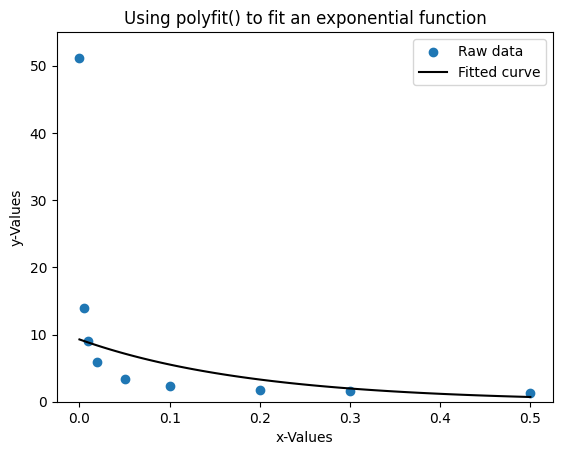

In [ ]:
a = np.exp(p[1])
b = p[0]
x_fitted = np.linspace(np.min(le3), np.max(le3), 100)
y_fitted = a * np.exp(b * x_fitted)

ax = plt.axes()
ax.scatter(le3, le2, label='Raw data')
ax.plot(x_fitted, y_fitted, 'k', label='Fitted curve')
ax.set_title('Using polyfit() to fit an exponential function')
ax.set_ylabel('y-Values')
ax.set_ylim(0, 55)
ax.set_xlabel('x-Values')
ax.legend()

48.072429453189976 -265.1748554709329 2.892366318235666


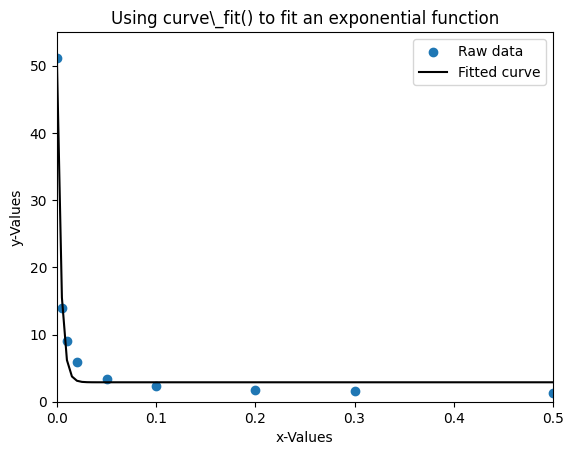

In [ ]:
from scipy.optimize import curve_fit

# Fit the function a * np.exp(b * t) + c to x and y
popt, pcov = curve_fit(lambda t, a, b, c: a * np.exp(b * t) + c, le3, le2)

a = popt[0]
b = popt[1]
c = popt[2]

x_fitted = np.linspace(np.min(le3), np.max(le3), 100)
y_fitted = a * np.exp(b * x_fitted) + c

ax = plt.axes()
ax.scatter(le3, le2, label='Raw data')
ax.plot(x_fitted, y_fitted, 'k', label='Fitted curve')
ax.set_title(r'Using curve\_fit() to fit an exponential function')
ax.set_ylabel('y-Values')
ax.set_ylim(0, 55)
ax.set_xlim(0,0.5)
ax.set_xlabel('x-Values')
ax.legend()

print(a,b,c)

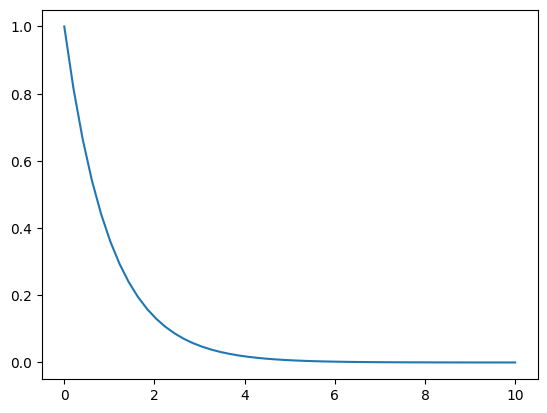

In [ ]:
k = np.linspace(0,10)
plt.figure()

plt.plot(k,np.exp(-k))

###ETSI on inverse

In [ ]:
def proxcalc3(x0,e1,e2,lbd,niter):
  k=0
  x=x0
  y_values=[]
  z_values=[]
  dy_x_values=[]
  x_values=[x0]
  dist_c=[np.linalg.norm(proj_C(x0) - x0)]
  while k<niter:
    y = (1/(2*e1+1))*(x + 2*e1*np.array(proj_primalexpcone(x)[0]))
    z = (1/(2*e2+1))*(2*y-x + 2*e2*np.array(proj_v2(2*y-x)))
    x = x + 2*lbd*(z-y)
    x_values.append(x)
    y_values.append(y)
    z_values.append(z)
    dist_c.append(np.linalg.norm(proj_C(x) - x))
    dy_x_values.append(proj_primalexpcone(2*y-x)[0] - 2*y-x)
    k+=1
  return x_values,y_values,z_values,dist_c,dy_x_values

In [ ]:
xv,yv,zv,dc,dyx = proxcalc3(np.array([1,1,1]),2,0.5,0.5,10000)

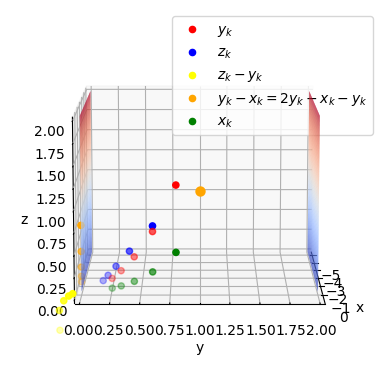

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

##########
u, v = np.mgrid[-5:0:100j, 0:2:80j]
x = u
y = 0
z = v

ax.plot_surface(x, y, z, cmap=cm.coolwarm)
############
u, v = np.mgrid[-5:0:100j, 0:2:80j]
x = u
y = 2
z = v

ax.plot_surface(x, y, z, cmap=cm.coolwarm)
############
ax.scatter(-2,1,1,color='orange', lw=3)

ax.scatter(np.array(yv)[0:5,2],np.array(yv)[0:5,1],np.array(yv)[0:5,0],color='red',label =r'$y_k$')
ax.scatter(np.array(zv)[0:5,2],np.array(zv)[0:5,1],np.array(zv)[0:5,0],color='blue',label =r'$z_k$')
ax.scatter(np.array(zv)[0:5,2] - np.array(yv)[0:5,2],np.array(zv)[0:5,1]- np.array(yv)[0:5,1],np.array(zv)[0:5,0]- np.array(yv)[0:5,0],color='yellow',label =r'$z_k - y_k$')
ax.scatter(np.array(yv)[0:5,2] - np.array(xv)[1:6,2],np.array(yv)[0:5,1]- np.array(xv)[1:6,1],np.array(yv)[0:5,0]- np.array(xv)[1:6,0],color='orange',label =r'$y_k - x_k = 2y_k - x_k - y_k$')
ax.scatter(np.array(xv)[1:6,2],np.array(xv)[1:6,1],np.array(xv)[1:6,0],color='green',label =r'$x_k$')



#ax.scatter(np.array(deuyx)[:,2],np.array(deuyx)[:,1],np.array(deuyx)[:,0],color='purple',label =r'$2y_k - x_k$')


"""
ax.scatter(np.array(x_v_CPA_V1)[920,2],np.array(x_v_CPA_V1)[920,1],np.array(x_v_CPA_V1)[920,0],color='orange',lw=10) #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y
ax.scatter(np.array(x_v_CPA_V1)[921,2],np.array(x_v_CPA_V1)[921,1],np.array(x_v_CPA_V1)[921,0],color='yellow',lw=20) #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y
ax.scatter(np.array(x_v_V1)[8,2],np.array(x_v_V1)[8,1],np.array(x_v_V1)[8,0],color='green') #on trace le 8 eme point pr voir ou il est et surtout sa valeur en y
"""

# Some other effects you may want to try based on your needs:
# ax.plot_surface(x, y, -z, cmap=cm.coolwarm)
# ax.scatter3D(x, y, z, color="b")
# ax.plot_wireframe(x, y, z, color="b")
# ax.plot_wireframe(x, y, -z, color="r")

# Can set your view from different angles.
plt.legend()
ax.view_init(azim=0, elev=10)
ax.set_zlim(0,2)
ax.set_ylim(0,2)
#ax.set_xlim(-1,1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

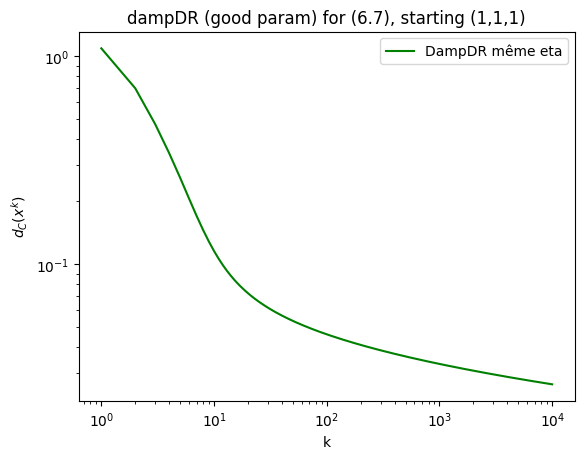

In [ ]:
plt.figure()
k =np.linspace(1,10**4,10**4)
plt.loglog(k[:len(dc)-1],dc[1:],color='green',label='DampDR même eta')
#plt.loglog(k,np.exp(-0.4*k),color='black')
#plt.loglog(k,np.exp(-0.5*k),color='red',label='exp(-0.5*k)')
#plt.loglog(k[0:10],np.exp(-0.5*k[0:10]),color='red')
plt.xlabel("k")
plt.ylabel(r'$d_C(x^k)$')
plt.title("dampDR (good param) for (6.7), starting (1,1,1)")
plt.legend()

# $\mathcal{V}_3$

For $\mathcal{V}_3 = \{ (x,0,0)\in\mathbb{R}\}$, we have


On remarque que $C^{**} = K_{exp}\cap\mathcal{V}_3 = C$.

Donc, \begin{equation}
\text{proj}_{C}(x) =
\left\{
\begin{array}{ll}
      x- (0,x_2,0), & x_1 \leq 0, x_3\geq0  \\
      x - (0,x_2,x_3), & x_1 \leq 0, x_3<0  \\
      x - (x_1,x_2,0), & x_1 > 0, x_3\geq0  \\
      0, & x_1 > 0, x_3<0  \\
\end{array}
\right.
\end{equation}

In [ ]:
def proj_v3(x):
  return [0,0,x[2]]

In [ ]:
def dykstra_V3(x0,niter):
  k=0
  x=x0
  p,q = np.array([0,0,0]), np.array([0,0,0])
  x_values=[x0]
  y_values=[proj_v3(x0)]
  dist_c=[np.linalg.norm(proj_C(x0) - x0)]
  x1mx=[]
  suite = [np.dot(x0 -proj_C(x0),q)]
  suite2 = [0]
  suite3=[]
  suite4=[0]
  suitec=[]
  print(proj_C(x0))
  while k<niter:
    #if isinC(x) : return x_values,dist_c
    y = proj_v3(x+p)
    if k ==1: suite4.pop()
    if k>=1: suite4.append(np.dot(np.array(y_values[-1]) - np.array(y),p))
    y_values.append(y)
    p = x+p-np.array(y)
    #print("y=",y)
    #print(p)
    suite2.append(np.dot(y-proj_C(x0),p))
    x= np.array(proj_primalexpcone(np.array(y)+q)[0])
    #print("x=",x)
    suite3.append(np.dot(x_values[-1] - x,q))
    q=np.array(y)+q-x
    #print("q=",q)
    x_values.append(x)
    suite.append(np.dot(x -proj_C(x0),q))
    #x_values.append(y)
    dist_c.append(np.linalg.norm(proj_C(x) - x))
    x1mx.append(np.linalg.norm(x_values[-1]-x_values[-2]))
    suitec.append(suite[-1] + suite2[-1] - suite[-2] - suite2[-2] + suite3[-1]+suite4[-1] +np.linalg.norm(y - x)**2)
    k+=1
  return x_values,dist_c,x1mx,suite,suite2,suite3,suitec

In [ ]:
x_dyk_3,d_c_dyk_3,x1mx_3,suite_3,suite2_3,suite3_3,suitec_3 = dykstra_V3(np.array([10,-1,1]),10**3)

[0 0 0]


[0.8922934685671972, 0.010351226086552147, 0.00012008143651098501, 1.3930283498759732e-06, 1.6160099678554195e-08, 1.8746841845804483e-10, 2.174764303248069e-12, 2.8274085187748162e-14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

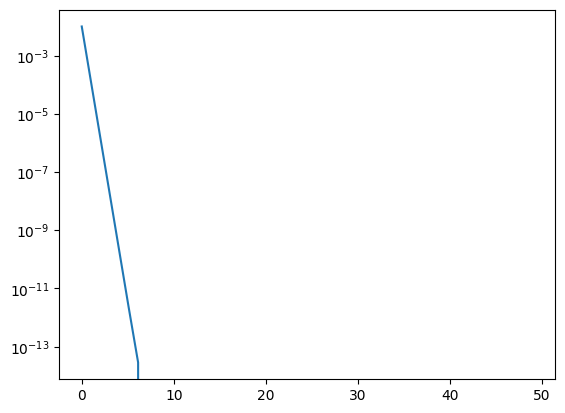

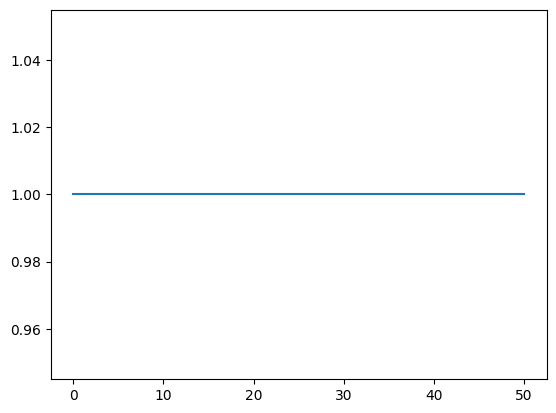

In [ ]:
plt.figure()

k = np.linspace(0,len(suitec_3[1:50]),len(suitec_3[1:50]))
plt.semilogy(k,suitec_3[1:50])

plt.figure(2)
print(suitec_3)

verifs2 = (np.array(suitec_3)>=0) * 1

k = np.linspace(0,len(verifs2[0:50]),len(verifs2[0:50]))
plt.plot(k,verifs2[0:50])

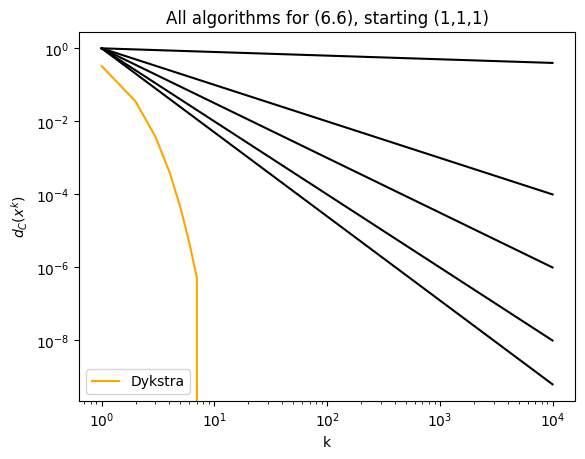

In [ ]:
plt.figure()
k =np.linspace(1,10**4,10**4)

plt.loglog(k,k**(-0.1),color='black')
plt.loglog(k,k**(-1),color='black')
plt.loglog(k,k**(-1.5),color='black')
plt.loglog(k,k**(-2),color='black')
plt.loglog(k,k**(-2.3),color='black')
#plt.loglog(k[:len(d_c_V1)-1],d_c_V1[1:],color='green',label='dampDR')
#plt.loglog(k[:len(d_c_V1)-1],d_c_V1[1:],color='blue',label='dampDR (bad param)')
plt.loglog(k[:len(d_c_dyk_3)-1],d_c_dyk_3[1:],color='orange',label='Dykstra')
#plt.loglog(k[:len(d_c_CPA_V1)-1],d_c_CPA_V1[1:],color='green',label="CPA")
#plt.loglog(k[:len(d_c_CPA)-1],d_c_CPA[1:],color='purple')
plt.xlabel("k")
plt.ylabel(r'$d_C(x^k)$')
plt.title("All algorithms for (6.6), starting (1,1,1)")
plt.legend()

#Conclusion

**CONCLUSION** : LE damp DR n'est pas forcément meilleur pour le problème $(6.6)$ : on suit la borne donnée par $𝚽^{-1}$. "almost linear"

**PAR CONTRE**, pour le probleme avec projection sur V2 (problème $(6.7)$), il est clairement **superlineaire**, ce qui est assez incroyable !